In [1]:
library(Seurat)
library(ggplot2)
library(sctransform)
library(Signac)
library(patchwork)
library(MAST)
library(gridExtra)
library(SeuratDisk)

library(RColorBrewer)

# Get a set of qualitative colors from ColorBrewer
colors_brewer <- brewer.pal(12, "Paired")

# Extend the list by adding more distinguishable colors
colors <- c(
    colors_brewer,
    "#8B0000",  # Dark Red
    "#FF4500",  # Orange Red
    "#2E8B57",  # Sea Green
    "#6A5ACD",  # Slate Blue
    "#DB7093",  # Pale Violet Red
    "#FF69B4",  # Hot Pink
    "#D2691E",  # Chocolate
    "#20B2AA",  # Light Sea Green
    "#FFD700",  # Gold
    "#C71585"   # Medium Violet Red
)


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, 

In [2]:
# load sobjs post mixscape
dasa1_ms <- readRDS("DASA1/seurat/06_mixscape_cc_filtered_DASA1_ngc.rds")
dasa2_ms <- readRDS("DASA2/seurat/06_mixscape_cc_filtered_DASA2_ngc.rds")
dmso1_ms <- readRDS("DMSO1/seurat/06_mixscape_cc_filtered_DMSO1_ngc.rds")
dmso2_ms <- readRDS("DMSO2/seurat/06_mixscape_cc_filtered_DMSO2_ngc.rds")

In [5]:
# merge
combined_ms <- merge(dasa1_ms, y = c(dasa2_ms, dmso1_ms, dmso2_ms), 
    add.cell.ids = c("DASA1", "DASA2", "DMSO1", "DMSO2"),
    merge.data = TRUE)


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows



In [6]:
# add sample ID
combined_ms$sample <- unlist(lapply(combined_ms$orig.ident, function(x) sub(".*-", "", x)))

In [7]:
# cells from each sample
table(combined_ms$sample)


DASA1 DASA2 DMSO1 DMSO2 
 2349  2466  1625  2042 

In [8]:
# function to test dims for umap
umap_dim_test <- function(sobj, dims_to_test = c(20,25,30,35,40,45,50), return_obj = FALSE, return_dim = 30){
    if(!return_obj){
        for(dim in dims_to_test){
            sobj <- RunPCA(sobj, verbose = FALSE)
            sobj <- RunUMAP(sobj, dims = 1:dim, verbose = FALSE)
            sobj <- FindNeighbors(sobj, dims = 1:dim, verbose = FALSE)
            sobj <- FindClusters(sobj, verbose = FALSE)
            print(DimPlot(sobj, reduction="umap", group.by = "Phase") + ggtitle(paste0(dim, " dims, Phase clusters")))
            print(DimPlot(sobj, reduction="umap") + ggtitle(paste0(dim, " dims, Leiden clusters")))
        }
    }
    else{
        sobj <- RunPCA(sobj, verbose = FALSE)
        sobj <- RunUMAP(sobj, dims = 1:return_dim, verbose = FALSE)
        sobj <- FindNeighbors(sobj, dims = 1:return_dim, verbose = FALSE)
        sobj <- FindClusters(sobj, verbose = FALSE)
        return(sobj)
    }
}

In [9]:
# function that regresses out cell cycle genes
# takes sobj and cell cycle genes as input
regress_cell_cycle_genes <- function(sobj, s.genes = cc.genes$s.genes, g2m.genes = cc.genes$g2m.genes){
    DefaultAssay(sobj) <- "RNA"
    # store mitochondrial percentage in object meta data
    sobj <- PercentageFeatureSet(sobj, pattern = "^MT-", col.name = "percent.mt")
    # run sctransform
    sobj <- SCTransform(sobj, vars.to.regress = "percent.mt", verbose = FALSE)
    # cell cycle scoring
    sobj <- CellCycleScoring(sobj, 
        s.features = s.genes, 
        g2m.features = g2m.genes, 
        set.ident = TRUE)
    # Visualize the distribution of cell cycle markers across
    options(repr.plot.width = 12, repr.plot.height = 8)
    print(RidgePlot(sobj, features = c("PCNA", "TOP2A", "MCM6", "MKI67"), ncol = 2))
    # Running a PCA on cell cycle genes reveal
    sobj <- RunPCA(sobj, features = c(s.genes, g2m.genes))
    print(DimPlot(sobj, group.by = "Phase"))
    # rerun sctransform
    sobj <- SCTransform(sobj, 
        vars.to.regress = c("S.Score", "G2M.Score"), 
        verbose = FALSE)
    # run function to compare different umap dims for our samples
    umap_dim_test(sobj)
    return(sobj)
}

In [11]:
# run clustering with optimal number of clusters from previous cell
combined_ms <- umap_dim_test(combined_ms, return_obj = TRUE, return_dim = 45)

In [18]:
# add dmso vs dasa
combined_ms$treatment <-  unlist(lapply(combined_ms$sample, function(x) sub("^(.{4}).*", "\\1", x)))

# Figure 3B

In [ ]:
DimPlot(combined_ms, label=TRUE, group.by= "sample", reduction="umap")

# Figure 3E

In [ ]:
DimPlot(combined_ms, label=TRUE, group.by= "treatment", reduction="umap")

In [20]:
table(combined_ms$mixscape_class)


    ADNP-1_ADNP-2 KD            BRD2-1 KD            CHD2-1 KD 
                 119                  184                   52 
    CHD2-1_CHD2-2 KD         GPBP1L1-1 KD            HIC2-1 KD 
                 239                  387                   51 
    HIC2-1_HIC2-2 KD            HIC2-2 KD           KMT2B-2 KD 
                 506                   66                  384 
      MNT-1_MNT-2 KD                   NT           PIAS1-1 KD 
                  28                 4545                  142 
  PIAS1-1_PIAS1-2 KD          PLAGL2-1 KD PLAGL2-1_PLAGL2-2 KD 
                 505                   44                   43 
          PQBP1-1 KD            SLTM-1 KD          YEATS4-1 KD 
                 103                  361                  100 
YEATS4-1_YEATS4-2 KD          YEATS4-2 KD           ZBED6-1 KD 
                 235                   40                  139 
         ZNF669-2 KD 
                 209 

In [21]:
combined_ms

An object of class Seurat 
345160 features across 8482 samples within 4 assays 
Active assay: SCT (22289 features, 3000 variable features)
 3 other assays present: ATAC, RNA, PRTB
 2 dimensional reductions calculated: pca, umap

# RNA DEA

In [23]:
table(combined_ms$guidecapture_classification, useNA = "a")


    ADNP-1_ADNP-2            BRD2-1            CHD2-1     CHD2-1_CHD2-2 
              119               184                52               239 
        GPBP1L1-1            HIC2-1     HIC2-1_HIC2-2            HIC2-2 
              387                51               506                66 
          KMT2B-2       MNT-1_MNT-2                NT           PIAS1-1 
              384                28              4545               142 
  PIAS1-1_PIAS1-2          PLAGL2-1 PLAGL2-1_PLAGL2-2           PQBP1-1 
              505                44                43               103 
           SLTM-1          YEATS4-1 YEATS4-1_YEATS4-2          YEATS4-2 
              361               100               235                40 
          ZBED6-1          ZNF669-2              <NA> 
              139               209                 0 

In [24]:
# Create a new column based on the values in "treatment" and "guidecapture_classfication"
combined_ms$treatment_and_guidecapture <- paste(combined_ms$treatment, 
                                                                   sub("-.*", "", combined_ms$guidecapture_classification), 
                                                                   sep = "_")

In [25]:
table(combined_ms$treatment_and_guidecapture)


   DASA_ADNP    DASA_BRD2    DASA_CHD2 DASA_GPBP1L1    DASA_HIC2   DASA_KMT2B 
          15           34          237          146          401          221 
     DASA_NT   DASA_PIAS1  DASA_PLAGL2   DASA_PQBP1    DASA_SLTM  DASA_YEATS4 
        2793          327           87          103          242          125 
 DASA_ZNF669    DMSO_ADNP    DMSO_BRD2    DMSO_CHD2 DMSO_GPBP1L1    DMSO_HIC2 
          84          104          150           54          241          222 
  DMSO_KMT2B     DMSO_MNT      DMSO_NT   DMSO_PIAS1    DMSO_SLTM  DMSO_YEATS4 
         163           28         1752          320          119          250 
  DMSO_ZBED6  DMSO_ZNF669 
         139          125 

In [28]:
# set the idents so we can perform DEA
Idents(object = combined_ms) <- combined_ms$treatment_and_guidecapture

In [31]:
# DMSO vs DASA NT markers
NT.de.markers <- FindMarkers(combined_ms, ident.1 = "DASA_NT", ident.2 = "DMSO_NT", 
                             only.pos = F, logfc.threshold = 1, test.use = "wilcox", min.pct = 0.5)
dim(NT.de.markers)
# view results
head(NT.de.markers)

# Sort the dataframe by a log2FC in descending order
NT.de.markers <- NT.de.markers[order(NT.de.markers$avg_log2FC, decreasing = TRUE), ]
write.csv(NT.de.markers, 
file = '{PATH_1}')
head(NT.de.markers, 20)

[1] 102   5

p_val avg_log2FC pct.1 pct.2 p_val_adj
ENO1     0     -1.423533  0.406 0.946 0        
ERMAP    0      1.168786  0.839 0.328 0        
NPL      0      1.177582  0.874 0.445 0        
CR1L     0      2.049746  0.981 0.459 0        
SLC30A10 0      1.227205  0.708 0.126 0        
SMYD3    0     -1.436383  0.921 0.980 0

p_val avg_log2FC pct.1 pct.2 p_val_adj
HBZ        0     5.141196   1.000 0.555 0        
HBG2       0     3.765206   1.000 0.866 0        
HBG1       0     2.773844   0.997 0.664 0        
SLC25A37   0     2.733092   1.000 0.842 0        
PTH2R      0     2.516123   0.996 0.523 0        
GYPB       0     2.490677   1.000 0.896 0        
APOE       0     2.340496   1.000 0.978 0        
BLVRB      0     2.322901   0.986 0.282 0        
CR1L       0     2.049746   0.981 0.459 0        
ALAS2      0     2.042792   0.942 0.150 0        
AC079804.3 0     2.016403   0.892 0.261 0        
CPQ        0     1.972660   0.996 0.654 0        
COL18A1    0     1.745682   0.982 0.537 0        
PLCG2      0     1.665425   1.000 0.928 0        
GP1BB      0     1.572636   1.000 0.955 0        
KEL        0     1.554478   0.889 0.269 0        
ZNF431     0     1.537193   0.958 0.535 0        
HBA1       0     1.520858   0.784 0.129 0        
TESC       0     1.488550   0.914 0.335 0        
APOC1      0     1.485086   1.000 0.986 0

In [34]:
# DMSO vs DASA HIC2 markers
HIC2.de.markers <- FindMarkers(combined_ms, ident.1 = "DASA_HIC2", ident.2 = "DMSO_HIC2", 
                             only.pos = F, logfc.threshold = 1, test.use = "wilcox", min.pct = 0.5)

dim(HIC2.de.markers)
# view results
head(HIC2.de.markers)

# Sort the dataframe by a log2FC in descending order
HIC2.de.markers <- HIC2.de.markers[order(HIC2.de.markers$avg_log2FC, decreasing = TRUE), ]
write.csv(HIC2.de.markers, 
file = '{PATH_2}')
head(HIC2.de.markers, 20)

[1] 92  5

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
HBZ      4.201684e-95 4.600747   1.000 0.829 9.365133e-91
HBG2     1.213541e-94 3.069305   1.000 0.995 2.704863e-90
GYPB     8.375370e-93 2.411607   1.000 0.928 1.866786e-88
SLC25A37 3.270534e-90 2.352900   1.000 0.928 7.289693e-86
HBG1     1.087062e-89 2.317307   1.000 0.950 2.422951e-85
BLVRB    5.250772e-88 2.167647   0.998 0.563 1.170345e-83

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
HBZ        4.201684e-95 4.600747   1.000 0.829 9.365133e-91
HBG2       1.213541e-94 3.069305   1.000 0.995 2.704863e-90
AC079804.3 3.883330e-81 2.455392   0.963 0.306 8.655555e-77
HBA1       4.597139e-83 2.444359   0.978 0.405 1.024656e-78
GYPB       8.375370e-93 2.411607   1.000 0.928 1.866786e-88
SLC25A37   3.270534e-90 2.352900   1.000 0.928 7.289693e-86
HBG1       1.087062e-89 2.317307   1.000 0.950 2.422951e-85
CR1L       2.507951e-82 2.224279   0.998 0.617 5.589973e-78
BLVRB      5.250772e-88 2.167647   0.998 0.563 1.170345e-83
APOE       1.352307e-78 2.157334   0.998 0.869 3.014157e-74
PTH2R      2.787481e-70 1.958204   0.985 0.441 6.213017e-66
ZNF431     2.699290e-71 1.744267   0.975 0.590 6.016448e-67
ALAS2      1.369331e-71 1.733655   0.905 0.198 3.052101e-67
CPQ        2.841130e-67 1.627527   0.975 0.523 6.332595e-63
APOC1      3.493325e-70 1.551369   1.000 0.973 7.786272e-66
PKHD1L1    9.012762e-56 1.493147   0.893 0.365 2.008855e-51
SLC4A1     5.274432e-53 1.463770   0.678 0.009 1.175618e-48
GP1BB      3.153299e-59 1.450360   1.000 0.923 7.028389e-55
COL18A1    1.760920e-64 1.437483   0.973 0.491 3.924914e-60
TESC       1.541455e-56 1.411708   0.900 0.360 3.435749e-52

In [35]:
# DMSO vs DASA PIAS1 markers
PIAS1.de.markers <- FindMarkers(combined_ms, ident.1 = "DASA_PIAS1", ident.2 = "DMSO_PIAS1", 
                             only.pos = F, logfc.threshold = 1, test.use = "wilcox", min.pct = 0.5)
dim(PIAS1.de.markers)
# view results
head(PIAS1.de.markers)

# Sort the dataframe by a log2FC in descending order
PIAS1.de.markers <- PIAS1.de.markers[order(PIAS1.de.markers$avg_log2FC, decreasing = TRUE), ]
write.csv(PIAS1.de.markers, 
file = '{PATH_3}')
head(PIAS1.de.markers, 20)

[1] 124   5

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
ALAS2    1.170537e-111 2.220489   0.966 0.053 2.609010e-107
HBZ      1.814062e-109 5.460401   1.000 0.466 4.043364e-105
GYPB     4.848464e-107 3.091757   1.000 0.759 1.080674e-102
HBG2     5.122301e-107 3.970181   1.000 0.875 1.141710e-102
BLVRB    1.243767e-105 2.391181   0.994 0.300 2.772232e-101
SLC25A37 1.929856e-105 3.127165   0.997 0.828 4.301455e-101

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
HBZ        1.814062e-109 5.460401   1.000 0.466 4.043364e-105
HBG2       5.122301e-107 3.970181   1.000 0.875 1.141710e-102
SLC25A37   1.929856e-105 3.127165   0.997 0.828 4.301455e-101
GYPB       4.848464e-107 3.091757   1.000 0.759 1.080674e-102
HBG1       1.184714e-103 3.040891   0.997 0.625  2.640609e-99
APOE       1.353437e-104 2.766972   1.000 0.978 3.016675e-100
PTH2R       1.331512e-96 2.444444   0.997 0.544  2.967806e-92
BLVRB      1.243767e-105 2.391181   0.994 0.300 2.772232e-101
CR1L        6.719061e-97 2.271564   0.988 0.403  1.497611e-92
ALAS2      1.170537e-111 2.220489   0.966 0.053 2.609010e-107
AC079804.3  1.714616e-85 2.200189   0.951 0.341  3.821707e-81
CPQ         1.087669e-94 1.988569   0.991 0.634  2.424306e-90
COL18A1     2.007924e-93 1.851470   0.991 0.447  4.475462e-89
APOC1       3.430976e-91 1.814606   1.000 0.997  7.647303e-87
GP1BB       1.061197e-77 1.740235   1.000 0.969  2.365303e-73
AC079801.1  9.531429e-88 1.640122   0.997 0.797  2.124460e-83
KEL         4.006608e-80 1.609051   0.920 0.294  8.930329e-76
TCF4        5.940245e-76 1.596047   0.994 0.816  1.324021e-71
TESC        8.294307e-74 1.579240   0.890 0.262  1.848718e-69
ZNF431      6.954925e-75 1.574434   0.966 0.531  1.550183e-70

In [36]:
# DASA HIC2 vs DASA NT
DASA.HIC2.NT.de.markers <- FindMarkers(combined_ms, ident.1 = "DASA_HIC2", ident.2 = "DASA_NT", 
                             only.pos = F, test.use = "wilcox")
dim(DASA.HIC2.NT.de.markers)
# view results
head(DASA.HIC2.NT.de.markers)

# Sort the dataframe by a log2FC in descending order
DASA.HIC2.NT.de.markers <- DASA.HIC2.NT.de.markers[order(DASA.HIC2.NT.de.markers$avg_log2FC, decreasing = TRUE), ]
write.csv(DASA.HIC2.NT.de.markers, 
file = '{PATH_4}')
head(DASA.HIC2.NT.de.markers, 20)

[1] 293   5

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
CTSE        0.000000e+00  1.0822441 0.546 0.005  0.000000e+00
STAR       2.297813e-155  0.8974807 0.494 0.058 5.121594e-151
HBG2       3.846958e-137  1.0341284 1.000 1.000 8.574484e-133
AC007563.2 5.308738e-134  0.5839419 0.339 0.023 1.183265e-129
ZFPM2      1.729989e-122 -1.2746313 0.823 0.990 3.855973e-118
ABCB9      4.741596e-115  0.7924573 0.454 0.071 1.056854e-110

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
HBA1       6.179477e-114 1.3735160  0.978 0.784 1.377344e-109
MGST3       2.636843e-99 1.1677155  0.815 0.409  5.877259e-95
PRDX2      2.151090e-104 1.1294963  0.970 0.769 4.794565e-100
AMMECR1     7.473797e-91 1.1196851  0.778 0.387  1.665835e-86
CTSE        0.000000e+00 1.0822441  0.546 0.005  0.000000e+00
HBG2       3.846958e-137 1.0341284  1.000 1.000 8.574484e-133
TMEM14B    4.987542e-115 0.9800129  0.988 0.939 1.111673e-110
HBG1       2.520832e-110 0.9639117  1.000 0.997 5.618682e-106
TMEM14C     1.867838e-90 0.9080709  0.993 0.940  4.163223e-86
STAR       2.297813e-155 0.8974807  0.494 0.058 5.121594e-151
ESPN        6.069523e-86 0.8526089  0.693 0.268  1.352836e-81
AC016629.2  2.195623e-73 0.8479293  0.781 0.406  4.893824e-69
SLC4A1      8.387273e-56 0.8217637  0.678 0.351  1.869439e-51
ABCB9      4.741596e-115 0.7924573  0.454 0.071 1.056854e-110
ATF7IP2     3.911407e-57 0.7729250  0.970 0.883  8.718136e-53
HBA2        1.099085e-43 0.7596913  0.501 0.219  2.449750e-39
AHSP        5.646928e-75 0.7431825  0.469 0.122  1.258644e-70
WIPF3       5.432204e-48 0.7330272  0.776 0.502  1.210784e-43
CR1L        1.517621e-64 0.7325299  0.998 0.981  3.382626e-60
AL442636.1  1.237334e-83 0.7049842  0.459 0.102  2.757894e-79

In [37]:
# DASA PIAS1 vs DASA NT
DASA.PIAS1.NT.de.markers <- FindMarkers(combined_ms, ident.1 = "DASA_PIAS1", ident.2 = "DASA_NT", 
                             only.pos = F, test.use = "wilcox")
dim(DASA.PIAS1.NT.de.markers)
# view results
head(DASA.PIAS1.NT.de.markers)

# Sort the dataframe by a log2FC in descending order
DASA.PIAS1.NT.de.markers <- DASA.PIAS1.NT.de.markers[order(DASA.PIAS1.NT.de.markers$avg_log2FC, decreasing = TRUE), ]
write.csv(DASA.PIAS1.NT.de.markers, 
file = '{PATH_5}')
head(DASA.PIAS1.NT.de.markers, 20)

[1] 45  5

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
PIAS1      1.538976e-113 -1.3824572 0.083 0.791 3.430223e-109
AC079801.1  7.435635e-67  0.7634252 0.997 0.956  1.657329e-62
MS4A3       1.818270e-46  0.7660858 0.927 0.740  4.052741e-42
AC079466.1  4.780192e-35  0.7400098 0.960 0.922  1.065457e-30
SH3GL3      2.329493e-33  0.5037378 0.431 0.161  5.192207e-29
TRIM24      6.222054e-28  0.5774577 0.820 0.646  1.386834e-23

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
MS4A3      1.818270e-46 0.7660858  0.927 0.740 4.052741e-42
MS4A4A     1.221155e-18 0.7648745  0.664 0.453 2.721833e-14
AC079801.1 7.435635e-67 0.7634252  0.997 0.956 1.657329e-62
AC079466.1 4.780192e-35 0.7400098  0.960 0.922 1.065457e-30
TRIM24     6.222054e-28 0.5774577  0.820 0.646 1.386834e-23
TFPI       1.204927e-16 0.5276070  0.590 0.398 2.685662e-12
IGFL2-AS1  1.193138e-21 0.5067254  0.541 0.299 2.659386e-17
SH3GL3     2.329493e-33 0.5037378  0.431 0.161 5.192207e-29
SQLE       9.515211e-14 0.4652972  0.881 0.817 2.120845e-09
TMEM70     4.871670e-21 0.4320689  0.336 0.146 1.085846e-16
TXNIP      4.864428e-21 0.4295348  0.963 0.914 1.084232e-16
AC016629.2 1.525445e-16 0.4208592  0.615 0.406 3.400064e-12
APOE       9.305242e-22 0.3843439  1.000 1.000 2.074045e-17
AL713998.1 9.572445e-10 0.3835341  0.804 0.774 2.133602e-05
SGCZ       5.451261e-09 0.3556955  0.245 0.131 1.215032e-04
SPECC1     3.055053e-19 0.3477261  0.453 0.230 6.809407e-15
AL713998.3 9.287220e-08 0.3444557  0.615 0.502 2.070028e-03
AC079804.3 8.662532e-12 0.3432625  0.951 0.892 1.930792e-07
NR2F2-AS1  1.887255e-12 0.3414616  0.413 0.242 4.206502e-08
HMGCS1     5.041106e-09 0.3382982  0.422 0.285 1.123612e-04

# ATAC DEA

In [38]:
# set default assay to ATAC
DefaultAssay(combined_ms) <- "ATAC"

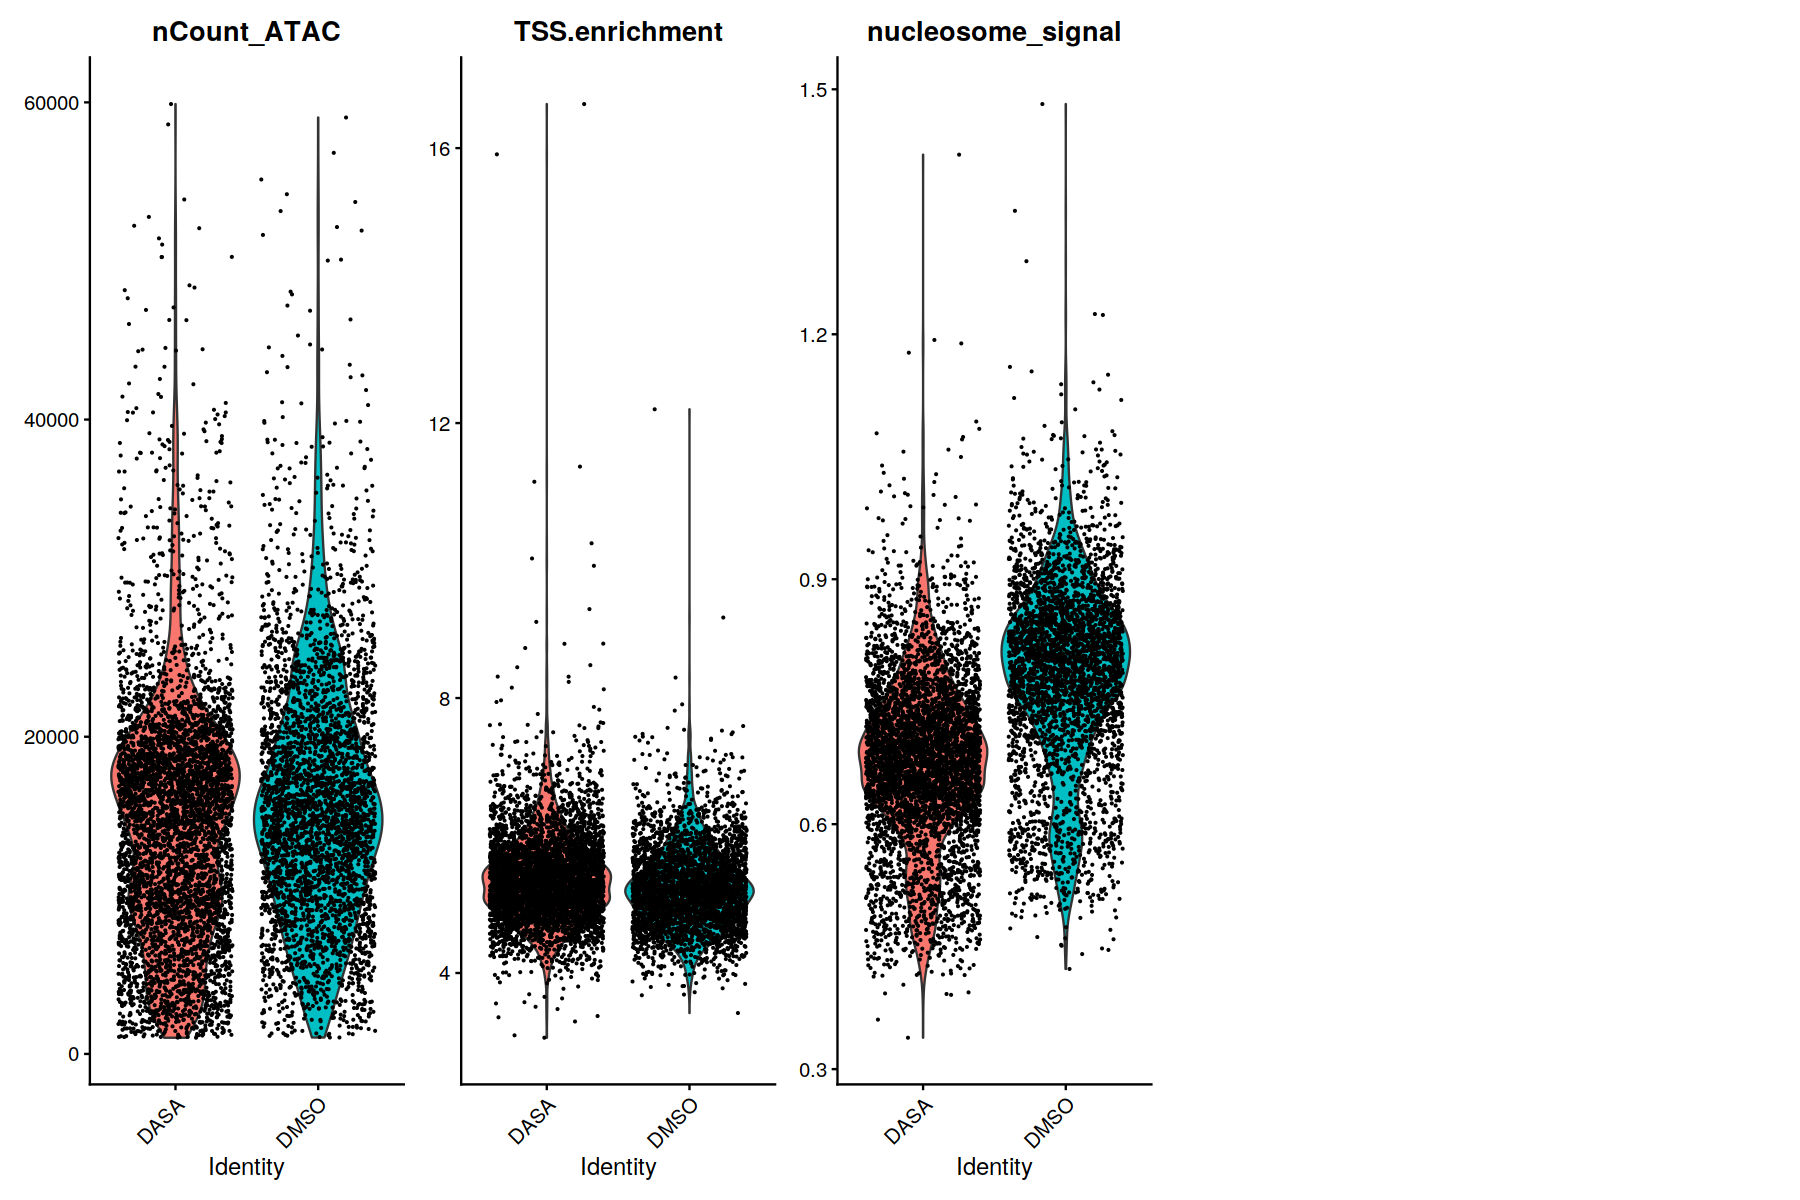

In [39]:
options(repr.plot.width = 15, repr.plot.height = 10)
Idents(combined_ms) <- "treatment"
VlnPlot(
  object = combined_ms,
  features = c('nCount_ATAC', 'TSS.enrichment', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [40]:
# filter outliers
# look into blacklist_ratio and pct_reads_in_peaks as additional filters
combined_ms <- subset(
  x = combined_ms,
  subset = nCount_ATAC > 3000 &
    nCount_ATAC < 40000 &
    nucleosome_signal < 1 &
    TSS.enrichment > 3.5 &
    TSS.enrichment < 7.5
)
combined_ms

An object of class Seurat 
345160 features across 7994 samples within 4 assays 
Active assay: ATAC (279098 features, 0 variable features)
 3 other assays present: SCT, RNA, PRTB
 2 dimensional reductions calculated: pca, umap

In [41]:
# normalization and LDR
combined_ms <- RunTFIDF(combined_ms)
combined_ms <- FindTopFeatures(combined_ms, min.cutoff = 'q0')
combined_ms <- RunSVD(combined_ms)

Performing TF-IDF normalization



Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”
Running SVD

Scaling cell embeddings



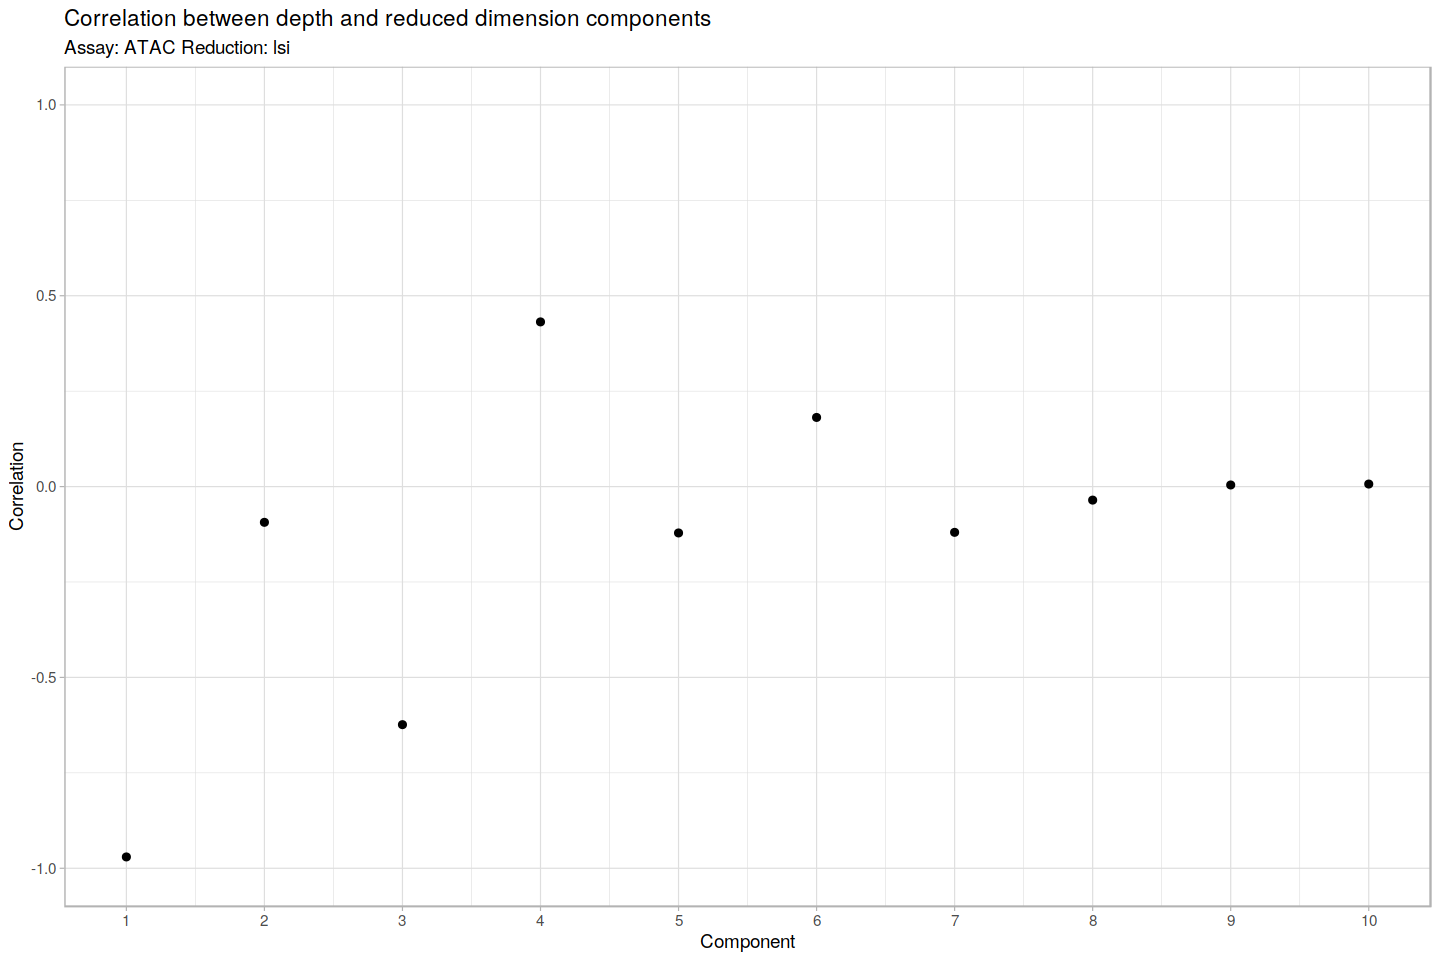

In [42]:
options(repr.plot.width = 12, repr.plot.height = 8)
DepthCor(combined_ms)

14:34:10 UMAP embedding parameters a = 0.9922 b = 1.112

14:34:10 Read 7994 rows and found 29 numeric columns

14:34:10 Using Annoy for neighbor search, n_neighbors = 30

14:34:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:34:11 Writing NN index file to temp file /tmp/Rtmp7ZnOoh/file36bc075644ecb2

14:34:11 Searching Annoy index using 1 thread, search_k = 3000

14:34:13 Annoy recall = 100%

14:34:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:34:17 Initializing from normalized Laplacian + noise (using irlba)

14:34:17 Commencing optimization for 500 epochs, with 322198 positive edges

14:34:27 Optimization finished

Computing nearest neighbor graph

Computing SNN



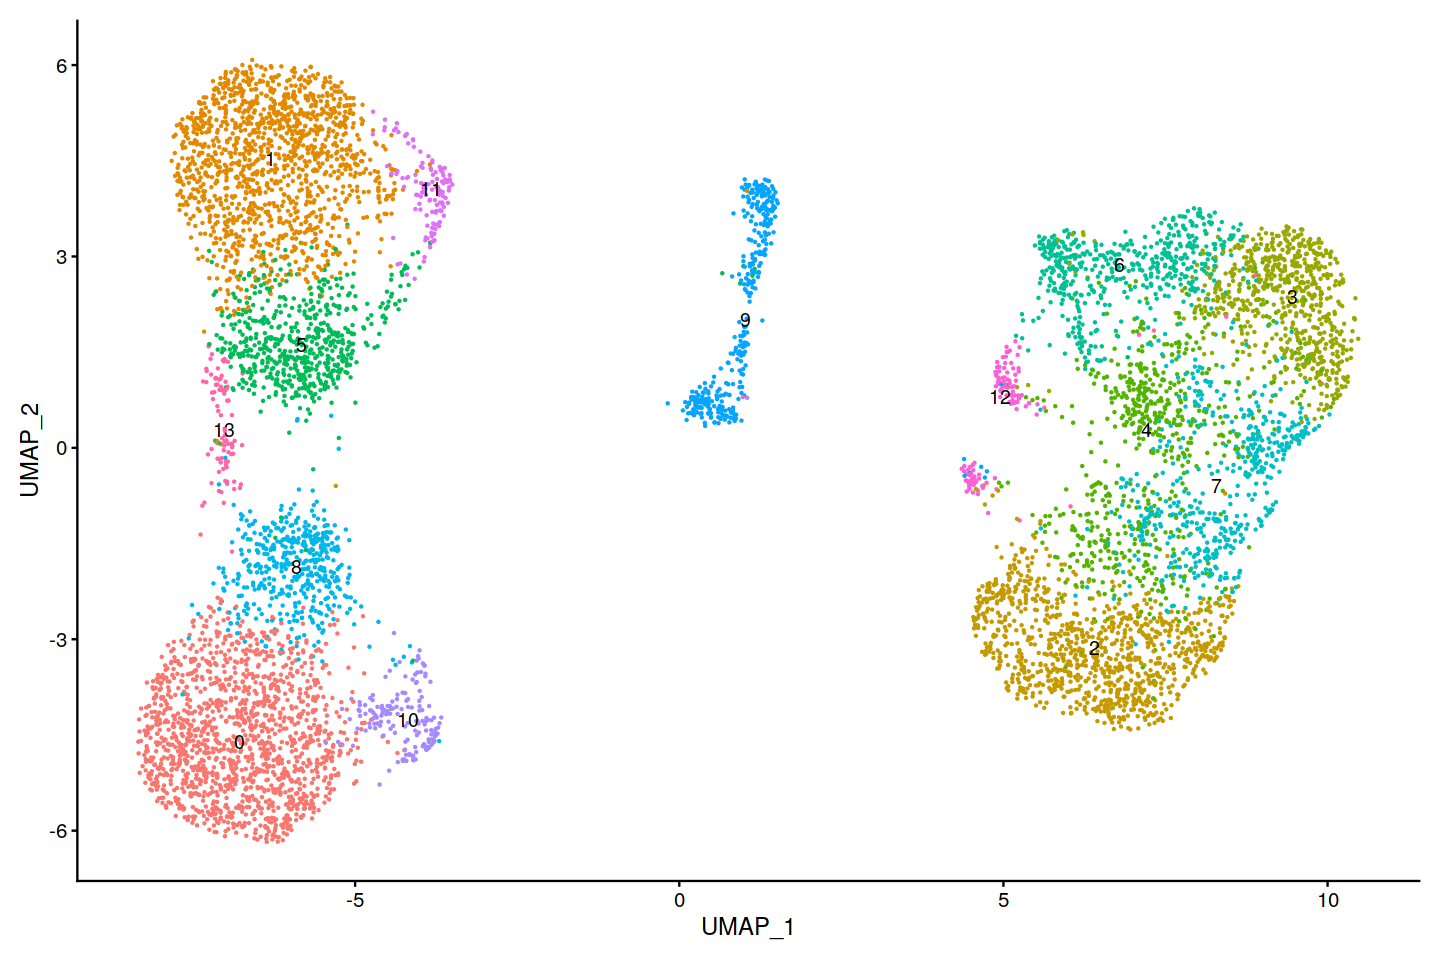

In [43]:
combined_ms <- RunUMAP(object = combined_ms, reduction = 'lsi', dims = 2:30)
combined_ms <- FindNeighbors(object = combined_ms, reduction = 'lsi', dims = 2:30)
combined_ms <- FindClusters(object = combined_ms, verbose = FALSE, algorithm = 3)
DimPlot(object = combined_ms, label = TRUE) + NoLegend()

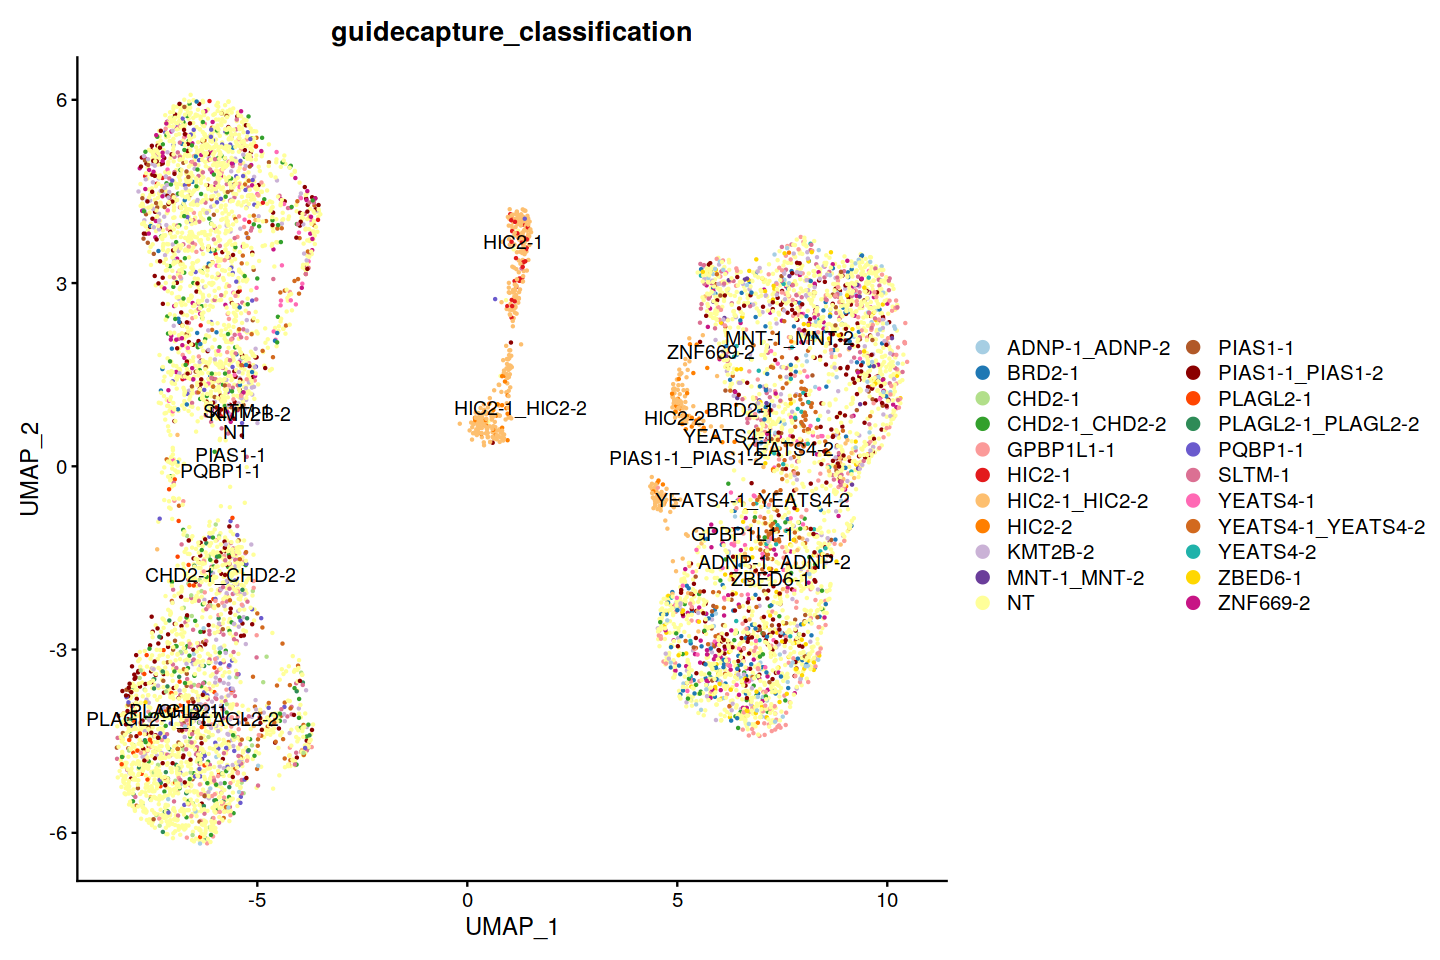

In [48]:
# umap computed with ATAC data and colored by guidecapture classification
DimPlot(object = combined_ms, label = TRUE, group.by = "guidecapture_classification", reduction = "umap", cols = colors)

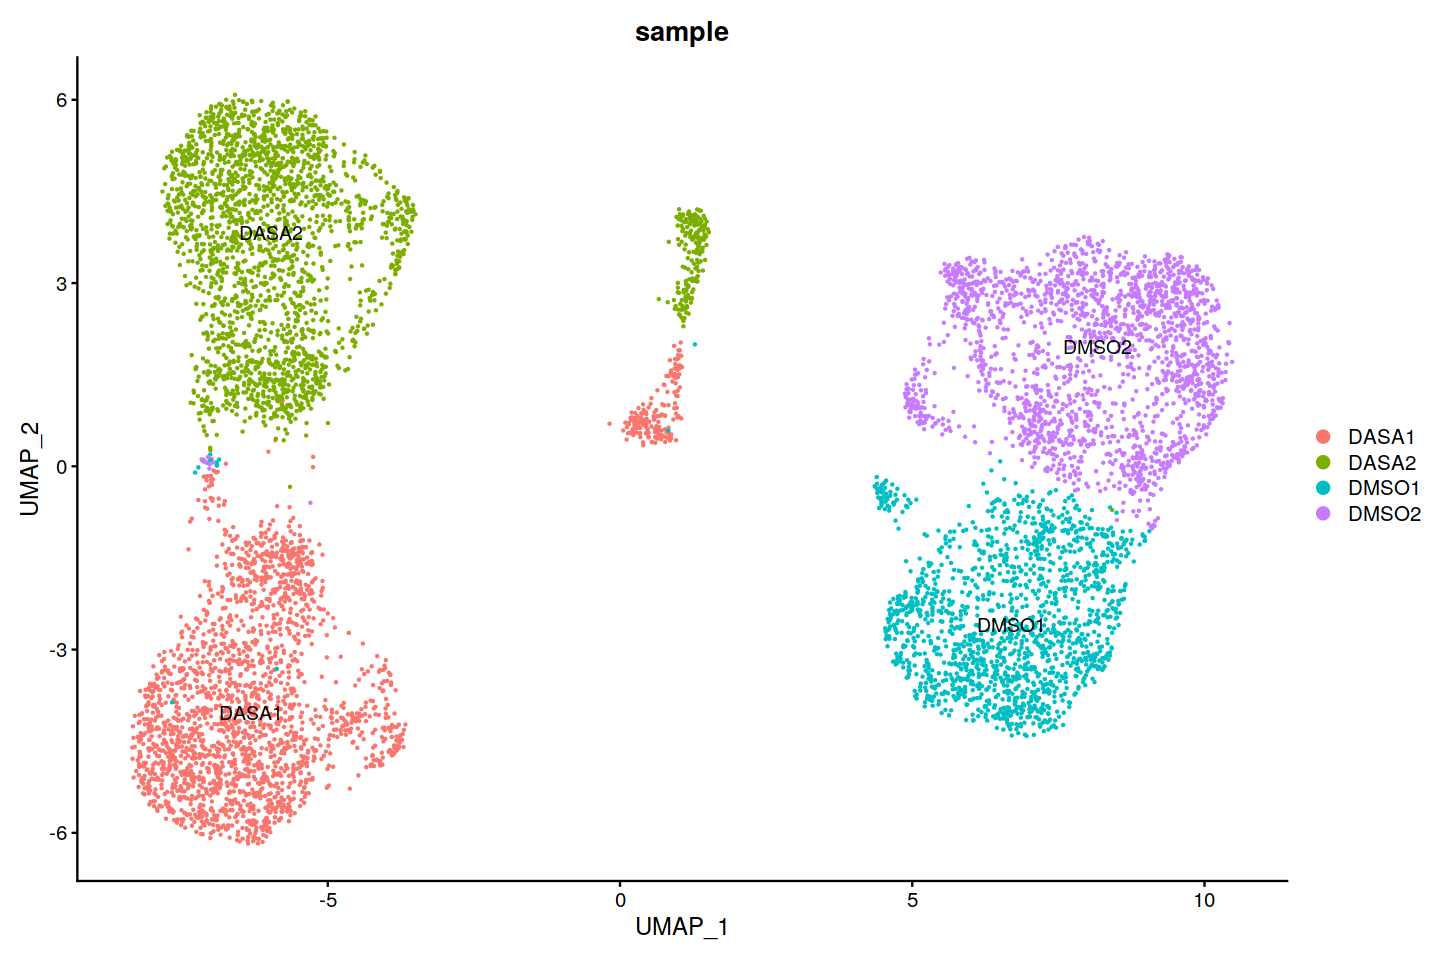

In [49]:
DimPlot(object = combined_ms, label = TRUE, group.by = "sample", reduction = "umap")

# Integrate ATAC Data
This step helps us remove our sample (DASA1, DASA2, DMSO1, DMSO2) batch effect.

In [50]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = list(subset(combined_ms, subset = sample == "DASA1"), 
                    subset(combined_ms, subset = sample == "DASA2"),
                    subset(combined_ms, subset = sample == "DMSO1"),
                    subset(combined_ms, subset = sample == "DMSO2")),
  anchor.features = rownames(combined_ms$SCT),
  reduction = "rlsi",
  dims = 2:50
)

Computing within dataset neighborhoods

Finding all pairwise anchors

Warning message:
“No filtering performed if passing to data rather than counts”
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 3680 anchors

Warning message:
“No filtering performed if passing to data rather than counts”
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1159 anchors

Warning message:
“No filtering performed if passing to data rather than counts”
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1172 anchors

Warning message:
“No filtering performed if passing to data rather than counts”
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1643 anchors

Warning message:
“No filtering performed if passing to data rather than counts”
Projecting new data onto SVD

Projecting new d

In [51]:
# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = combined_ms[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:50
)

# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:50, reduction.name = "atac.umap",
                     reduction.key = "atacUMAP_")

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 4 into 2 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 2 1 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

14:43:48 UMAP embedding parameters a = 0.9922 b = 1.112

14:43:48 Read 7994 rows and found 49 numeric columns

14:43:48 Using Annoy for neighbor search, n_neighbors = 30

14:43:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:43:49 Writing NN index file to temp file /tmp/Rtmp7ZnOoh/file36bc073e4a1bc9

14:43:49 Searching An

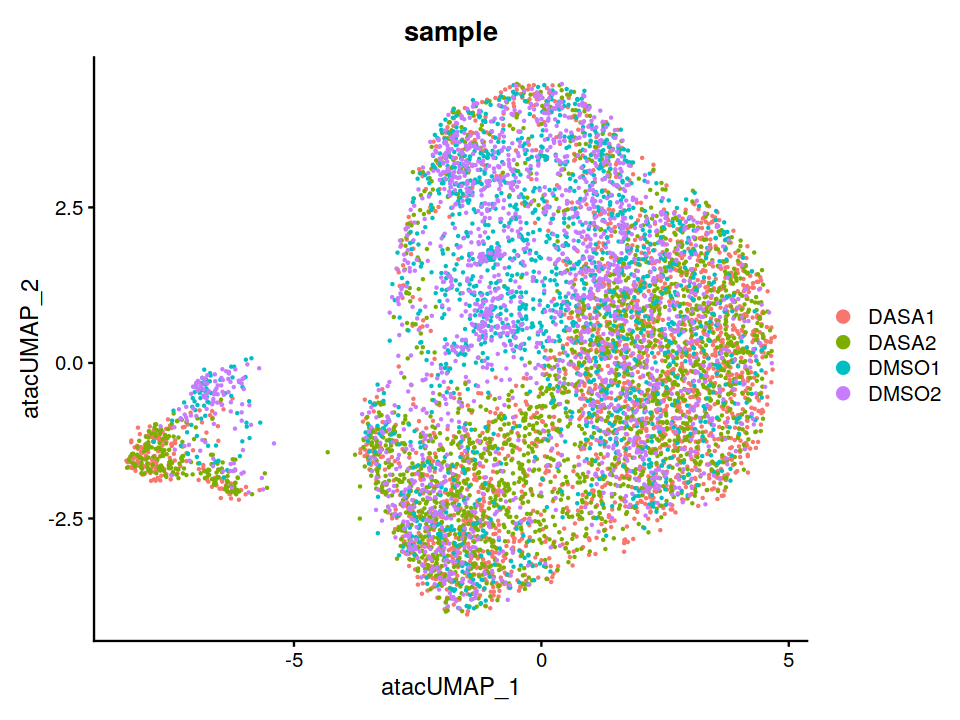

In [52]:
options(repr.plot.width = 8, repr.plot.height = 6)
p2 <- DimPlot(integrated, group.by = "sample")
p2

# ATAC DEA

### DASA VS DMSO NT

In [53]:
# set the idents so we can perform DEA
Idents(integrated) <- integrated$treatment_and_guidecapture
table(Idents(integrated))


     DASA_NT    DASA_HIC2   DASA_PIAS1    DASA_CHD2 DASA_GPBP1L1   DASA_PQBP1 
        2615          375          309          226          131          102 
  DASA_KMT2B    DASA_SLTM  DASA_PLAGL2  DASA_YEATS4    DASA_ADNP    DASA_BRD2 
         210          221           83          121           15           32 
 DASA_ZNF669   DMSO_KMT2B    DMSO_CHD2      DMSO_NT    DMSO_BRD2 DMSO_GPBP1L1 
          79          152           51         1661          148          222 
   DMSO_HIC2   DMSO_PIAS1   DMSO_ZBED6  DMSO_YEATS4  DMSO_ZNF669    DMSO_ADNP 
         216          299          126          241          121           98 
   DMSO_SLTM     DMSO_MNT 
         113           27 

In [54]:
# DASA vs DMSO NT ATAC DE
da_atac_NT <- FindMarkers(
  object = integrated,
  ident.1 = "DASA_NT",
  ident.2 = "DMSO_NT",
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

head(da_atac_NT)

dim(da_atac_NT)

# Sort the dataframe by a log2FC in descending order
da_atac_NT <- da_atac_NT[order(da_atac_NT$avg_log2FC, decreasing = TRUE), ]
write.csv(da_atac_NT, 
file = '{PATH_6}')
head(da_atac_NT, 20)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
chr3-9397364-9397750     0.000000e+00 -12.56311  0.000 0.421  0.000000e+00
chr22-23269998-23270907 9.464431e-309   3.34398  0.586 0.084 2.641504e-303
chr22-19179529-19180097 6.139837e-289 -12.44642  0.000 0.365 1.713616e-283
chr22-19721910-19722685 4.221485e-275 -12.34735  0.000 0.352 1.178208e-269
chr12-53380417-53380875 1.000263e-238  12.24171  0.346 0.000 2.791714e-233
chr20-45971756-45972159 1.138410e-225 -12.28494  0.000 0.296 3.177279e-220

[1] 9311    5

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
chr12-53380417-53380875  1.000263e-238 12.24171   0.346 0     2.791714e-233
chr5-128083278-128084034 1.925339e-193 12.14723   0.289 0     5.373583e-188
chr9-128249287-128249901 3.823217e-199 12.08969   0.294 0     1.067052e-193
chr22-21946220-21946985  4.353999e-159 11.95602   0.241 0     1.215192e-153
chr11-95790303-95790595  8.006430e-147 11.89272   0.224 0     2.234579e-141
chr1-37689352-37690113   4.557634e-135 11.82506   0.208 0     1.272027e-129
chr6-32970009-32970736   7.319543e-121 11.78715   0.188 0     2.042870e-115
chr7-133080811-133081499 3.809938e-125 11.78152   0.195 0     1.063346e-119
chr22-19942527-19943324  6.602981e-117 11.76977   0.183 0     1.842879e-111
chr1-43367135-43367656   1.488890e-121 11.76743   0.189 0     4.155463e-116
chr20-2872472-2872980    1.556645e-111 11.70951   0.175 0     4.344565e-106
chr6-42451672-42452478   1.858460e-104 11.70151   0.164 0      5.186926e-99
chr9-129886786-129887513 3.169838e-100 11.69612   0.159 0      8.846954e-95
chr8-123041709-123042007 1.240099e-111 11.68899   0.176 0     3.461091e-106
chr6-118709237-118710072 2.326340e-107 11.68284   0.168 0     6.492770e-102
chr19-491537-491791      9.770877e-101 11.64971   0.159 0      2.727032e-95
chr4-102826493-102827319  1.395025e-98 11.62596   0.156 0      3.893486e-93
chr20-41137872-41138341  1.666109e-103 11.62396   0.162 0      4.650078e-98
chrX-2629354-2630110      1.461862e-96 11.62365   0.152 0      4.080028e-91
chr11-68120277-68120987   1.033624e-89 11.62098   0.144 0      2.884823e-84

Warning message:
“Removed 14 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 131 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 27 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 78 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 86 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 41 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 164 rows containing missing values (`geom_segment()`).”


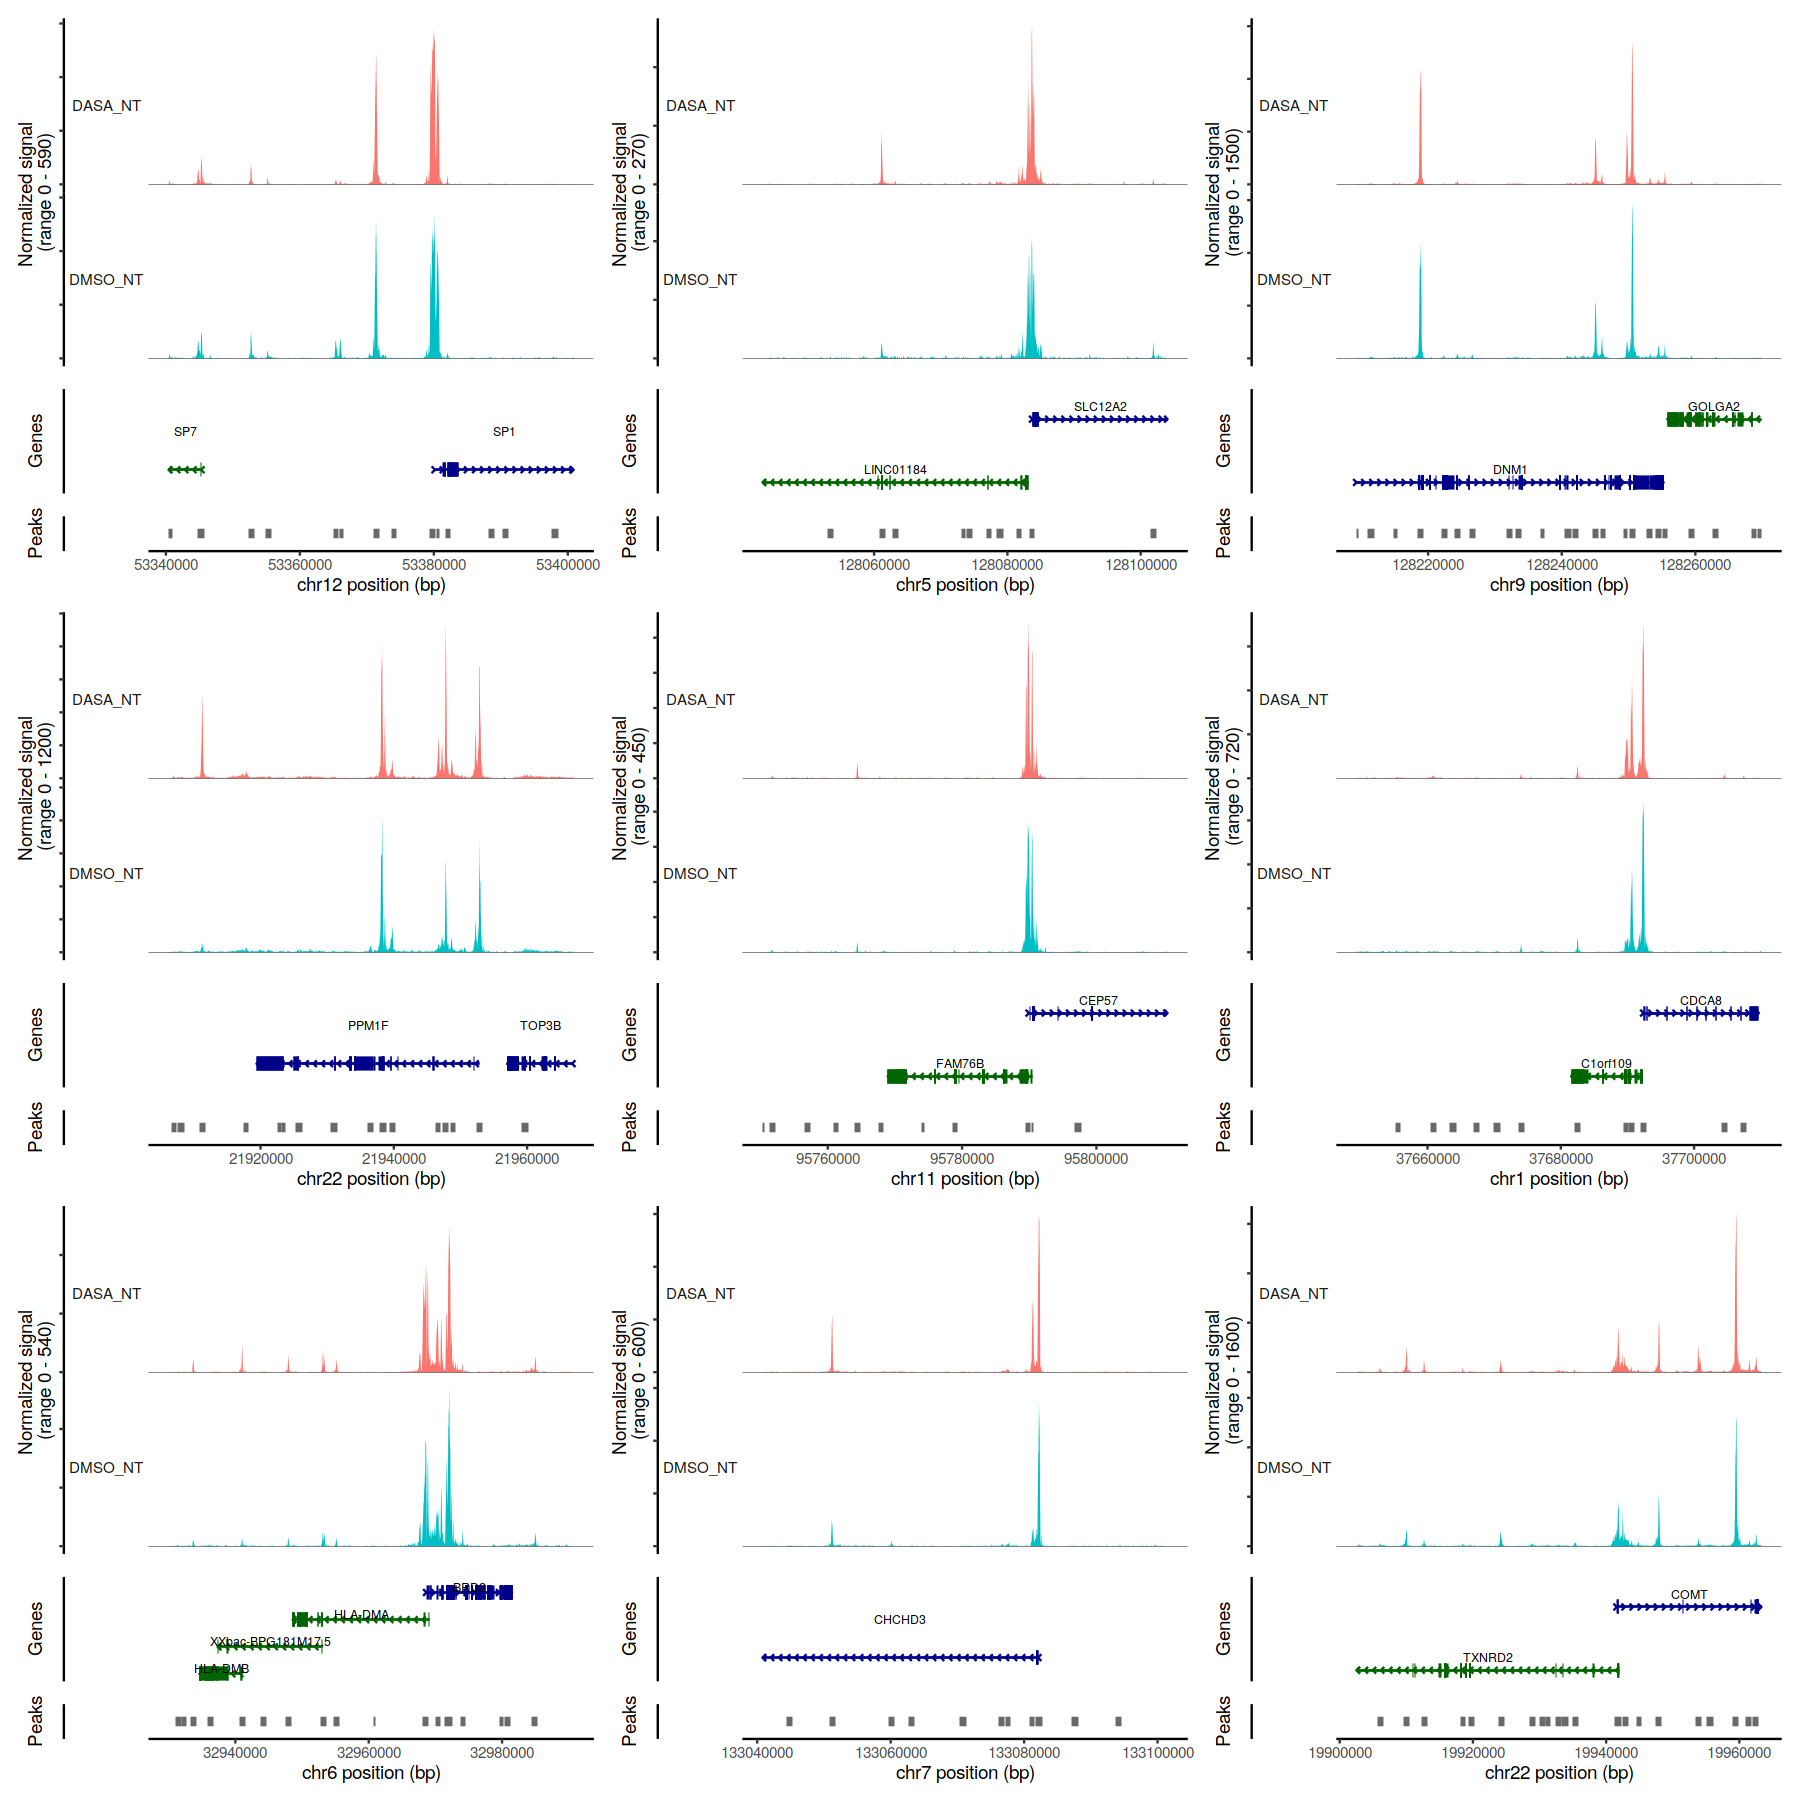

In [55]:
options(repr.plot.width = 15, repr.plot.height = 15)
CoveragePlot(
  object = subset(integrated, 
                  subset = treatment_and_guidecapture == "DASA_NT" | treatment_and_guidecapture == "DMSO_NT"),
    region = rownames(da_atac_NT)[1:9],
    extend.upstream = 40000,
    extend.downstream = 20000
)

### DASA VS DMSO HIC2

In [56]:
# DASA vs DMSO HIC2 ATAC DE
da_atac_HIC2 <- FindMarkers(
  object = integrated,
  ident.1 = "DASA_HIC2",
  ident.2 = "DMSO_HIC2",
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

head(da_atac_HIC2)

dim(da_atac_HIC2)

# Sort the dataframe by a log2FC in descending order
da_atac_HIC2 <- da_atac_HIC2[order(da_atac_HIC2$avg_log2FC, decreasing = TRUE), ]
write.csv(da_atac_HIC2, 
file = '{PATH_7}')
head(da_atac_HIC2, 20)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr3-9397364-9397750     7.074101e-47 -12.51666  0.000 0.417 1.974367e-41
chr22-19721910-19722685  1.798386e-42 -12.53678  0.000 0.384 5.019259e-37
chr22-19179529-19180097  1.848805e-42 -12.39303  0.000 0.380 5.159979e-37
chr19-4066941-4067686    1.268406e-36  12.94116  0.379 0.000 3.540097e-31
chr9-128249287-128249901 1.454738e-33  12.36838  0.344 0.000 4.060144e-28
chr12-53380417-53380875  2.929488e-32  12.13997  0.323 0.000 8.176144e-27

[1] 12798     5

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr19-4066941-4067686    1.268406e-36 12.94116   0.379 0     3.540097e-31
chr3-178790058-178790970 5.459261e-15 12.67178   0.160 0     1.523669e-09
chr2-239115028-239115942 3.113829e-14 12.60980   0.152 0     8.690636e-09
chr6-6891443-6892030     1.797651e-15 12.58877   0.165 0     5.017207e-10
chr3-13017845-13018699   1.336830e-16 12.58555   0.173 0     3.731065e-11
chr22-21753302-21753974  1.343041e-27 12.56652   0.288 0     3.748400e-22
chr1-37689352-37690113   1.422129e-27 12.47741   0.293 0     3.969134e-22
chr3-17227710-17228704   1.347134e-13 12.44797   0.144 0     3.759823e-08
chr4-44523996-44525063   5.105326e-12 12.41611   0.125 0     1.424886e-06
chr1-41412500-41413416   1.630768e-12 12.37993   0.136 0     4.551442e-07
chr7-100894030-100894518 2.364076e-14 12.36963   0.152 0     6.598088e-09
chr9-128249287-128249901 1.454738e-33 12.36838   0.344 0     4.060144e-28
chr1-204624684-204625410 1.249330e-17 12.26347   0.189 0     3.486855e-12
chr22-21686479-21687279  3.393383e-13 12.25167   0.144 0     9.470863e-08
chr2-219511351-219512275 5.429905e-18 12.20794   0.192 0     1.515476e-12
chr1-154944584-154945429 1.412313e-12 12.20225   0.133 0     3.941738e-07
chr1-228225518-228226440 5.373238e-10 12.18087   0.104 0     1.499660e-04
chr10-48545220-48546144  2.270536e-10 12.17545   0.109 0     6.337019e-05
chr19-1251907-1252672    1.953122e-15 12.17220   0.171 0     5.451125e-10
chr12-53380417-53380875  2.929488e-32 12.13997   0.323 0     8.176144e-27

Warning message:
“Removed 13 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 36 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 82 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 44 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 27 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 219 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


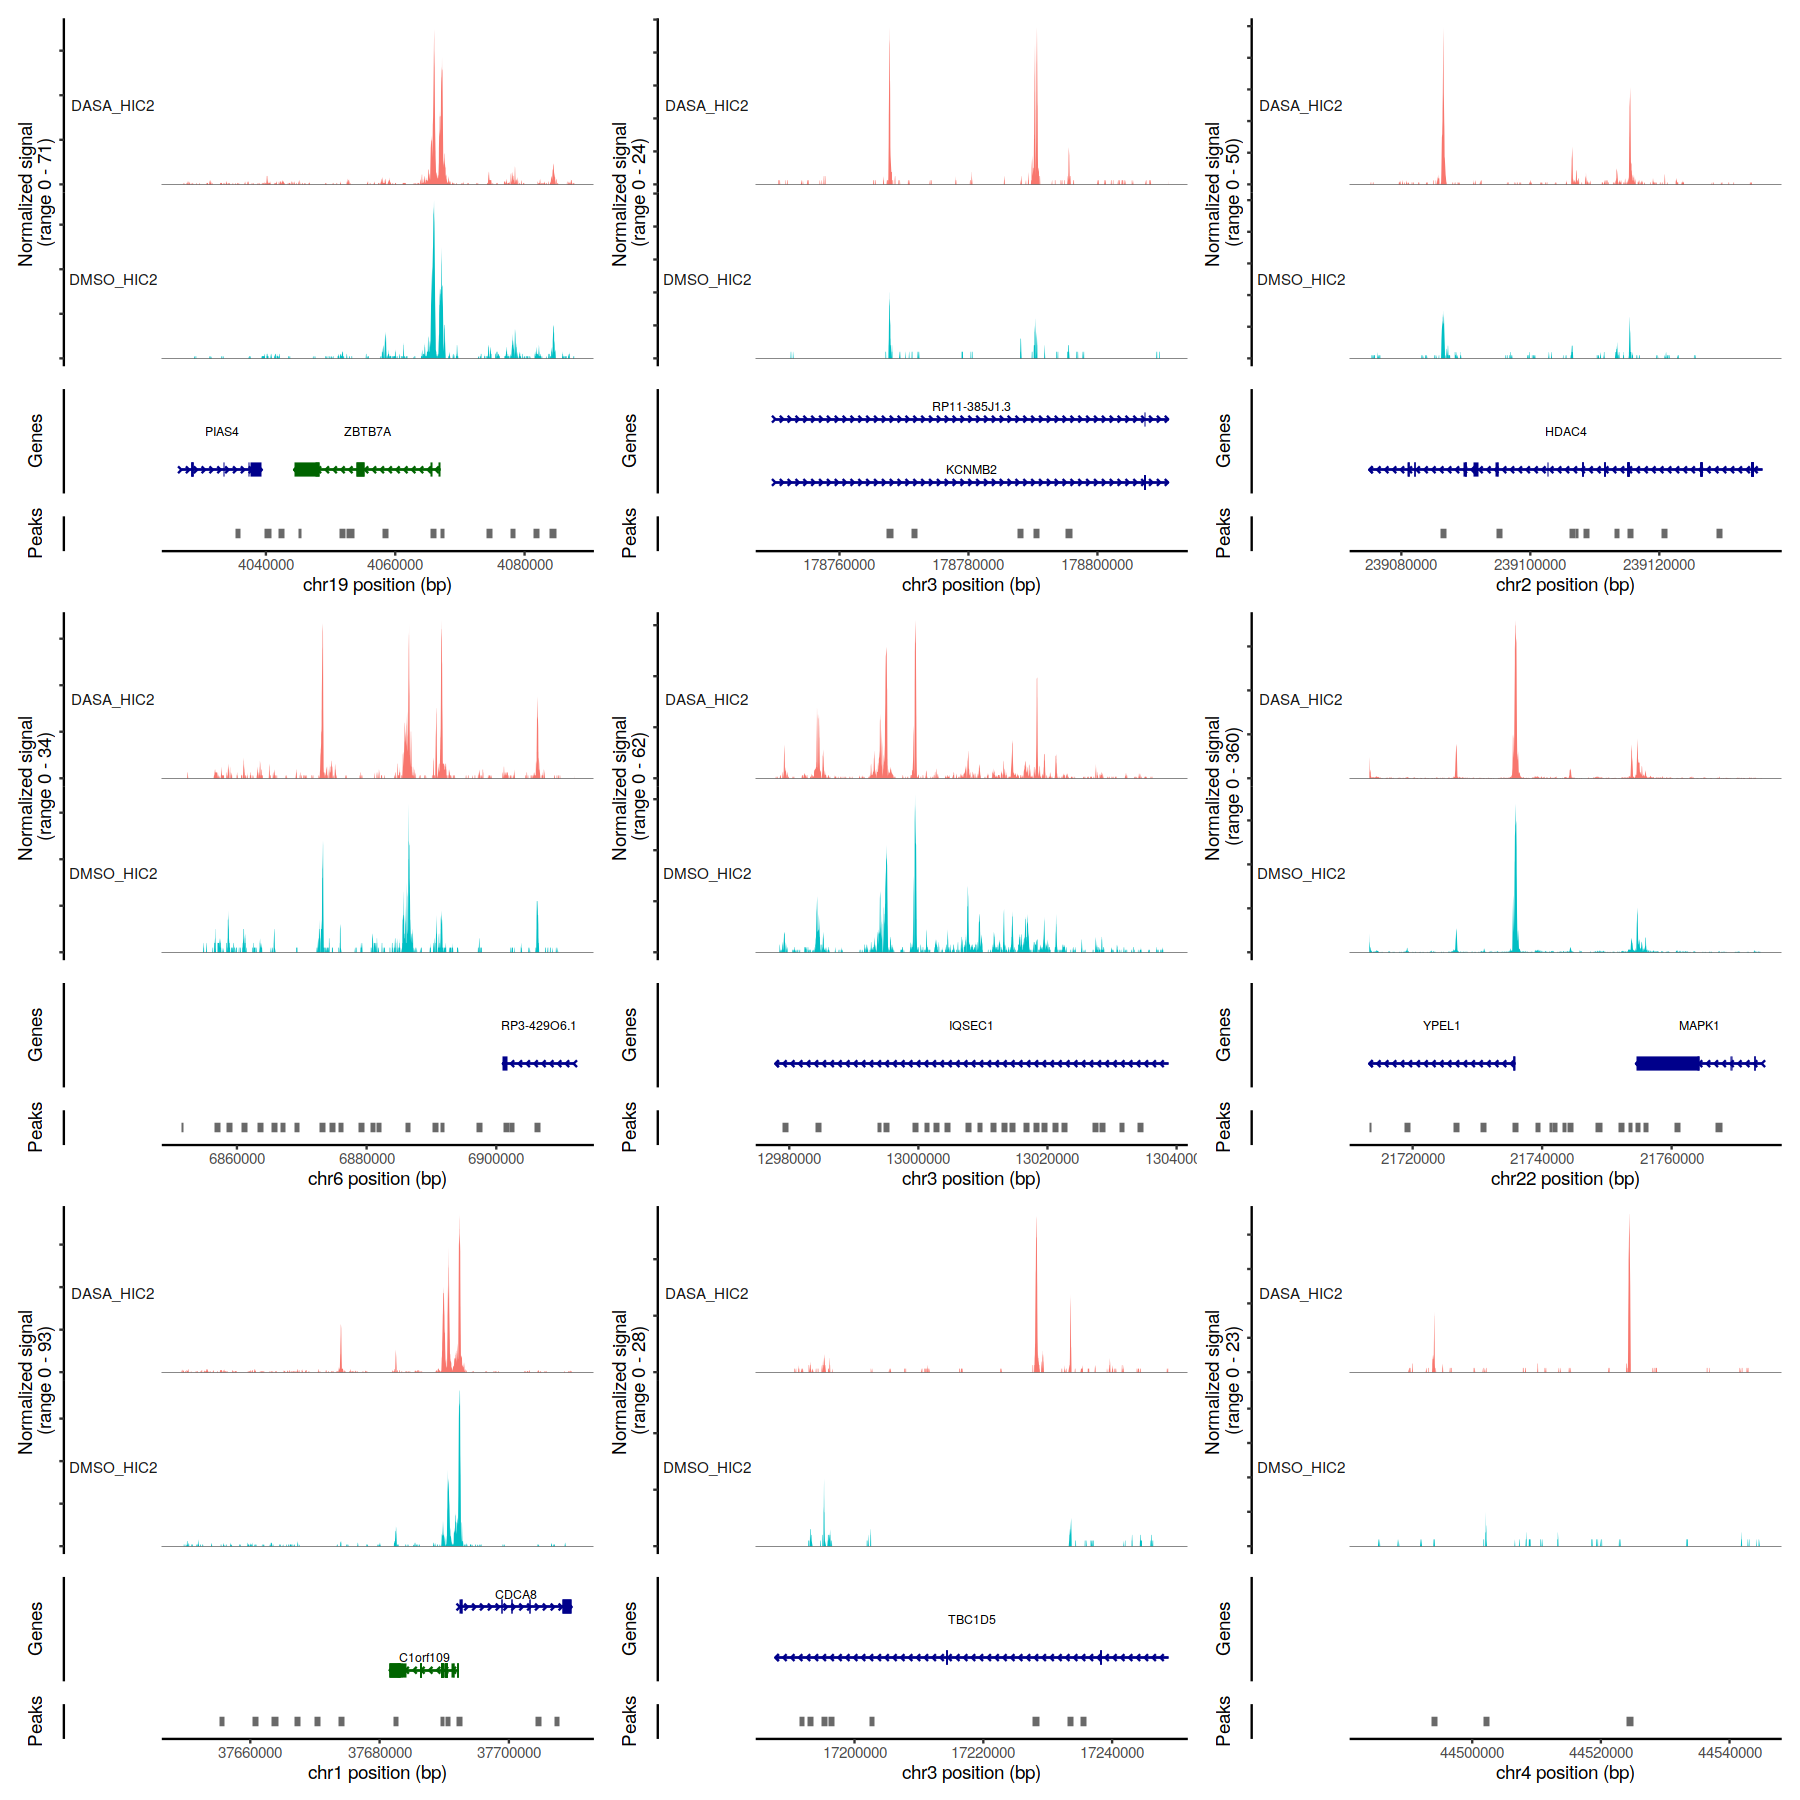

In [57]:
CoveragePlot(
  object = subset(integrated, 
                  subset = treatment_and_guidecapture == "DASA_HIC2" | treatment_and_guidecapture == "DMSO_HIC2"),
    region = rownames(da_atac_HIC2)[1:9],
    extend.upstream = 40000,
    extend.downstream = 20000
)

### DASA VS DMSO PIAS1

In [58]:
# DASA vs DMSO PIAS1 ATAC DE
da_atac_PIAS1 <- FindMarkers(
  object = integrated,
  ident.1 = "DASA_PIAS1",
  ident.2 = "DMSO_PIAS1",
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

head(da_atac_PIAS1)

dim(da_atac_PIAS1)

# Sort the dataframe by a log2FC in descending order
da_atac_PIAS1 <- da_atac_PIAS1[order(da_atac_PIAS1$avg_log2FC, decreasing = TRUE), ]
write.csv(da_atac_PIAS1, file = '{PATH_8}')
head(da_atac_PIAS1, 20)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr3-9397364-9397750     5.584384e-48 -12.524848 0.000 0.421 1.558590e-42
chr22-23269998-23270907  8.587268e-48   4.294309 0.505 0.037 2.396689e-42
chr22-19721910-19722685  3.652329e-44 -12.644973 0.000 0.395 1.019358e-38
chr12-53380417-53380875  2.028226e-36  12.140223 0.320 0.000 5.660739e-31
chr22-19179529-19180097  2.294463e-33 -12.136388 0.000 0.308 6.403800e-28
chr9-128249287-128249901 9.520372e-31  12.071968 0.275 0.000 2.657117e-25

[1] 12206     5

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr7-133080811-133081499 8.609649e-29 12.21509   0.259 0     2.402936e-23
chr22-21946220-21946985  1.345632e-29 12.17047   0.262 0     3.755633e-24
chr4-102826493-102827319 1.338078e-22 12.15973   0.210 0     3.734550e-17
chr12-53380417-53380875  2.028226e-36 12.14022   0.320 0     5.660739e-31
chr9-128249287-128249901 9.520372e-31 12.07197   0.275 0     2.657117e-25
chr14-46021922-46022828  8.282574e-20 12.02020   0.178 0     2.311650e-14
chr5-128083278-128084034 9.340763e-30 11.96937   0.262 0     2.606988e-24
chr19-491537-491791      4.294526e-21 11.96124   0.191 0     1.198594e-15
chr20-2872472-2872980    2.188154e-21 11.94544   0.194 0     6.107095e-16
chr6-32970009-32970736   3.317357e-22 11.86702   0.197 0     9.258677e-17
chr11-95790303-95790595  1.329410e-23 11.86698   0.214 0     3.710357e-18
chr8-123041709-123042007 1.667468e-20 11.86456   0.188 0     4.653869e-15
chr1-43367135-43367656   6.008766e-22 11.83323   0.194 0     1.677035e-16
chr1-228213518-228213809 4.418542e-18 11.76728   0.165 0     1.233206e-12
chr6-118709237-118710072 1.337724e-18 11.74348   0.168 0     3.733562e-13
chr20-346457-347267      2.101430e-17 11.69612   0.155 0     5.865048e-12
chr1-204493520-204494199 6.179061e-17 11.68990   0.149 0     1.724563e-11
chr20-41137872-41138341  1.080432e-17 11.67073   0.159 0     3.015465e-12
chr2-43227211-43227868   9.599939e-17 11.64098   0.152 0     2.679324e-11
chr1-52364893-52365415   8.440584e-16 11.63461   0.139 0     2.355750e-10

Warning message:
“Removed 41 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 78 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 27 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 17 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 131 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 129 rows containing missing values (`geom_segment()`).”


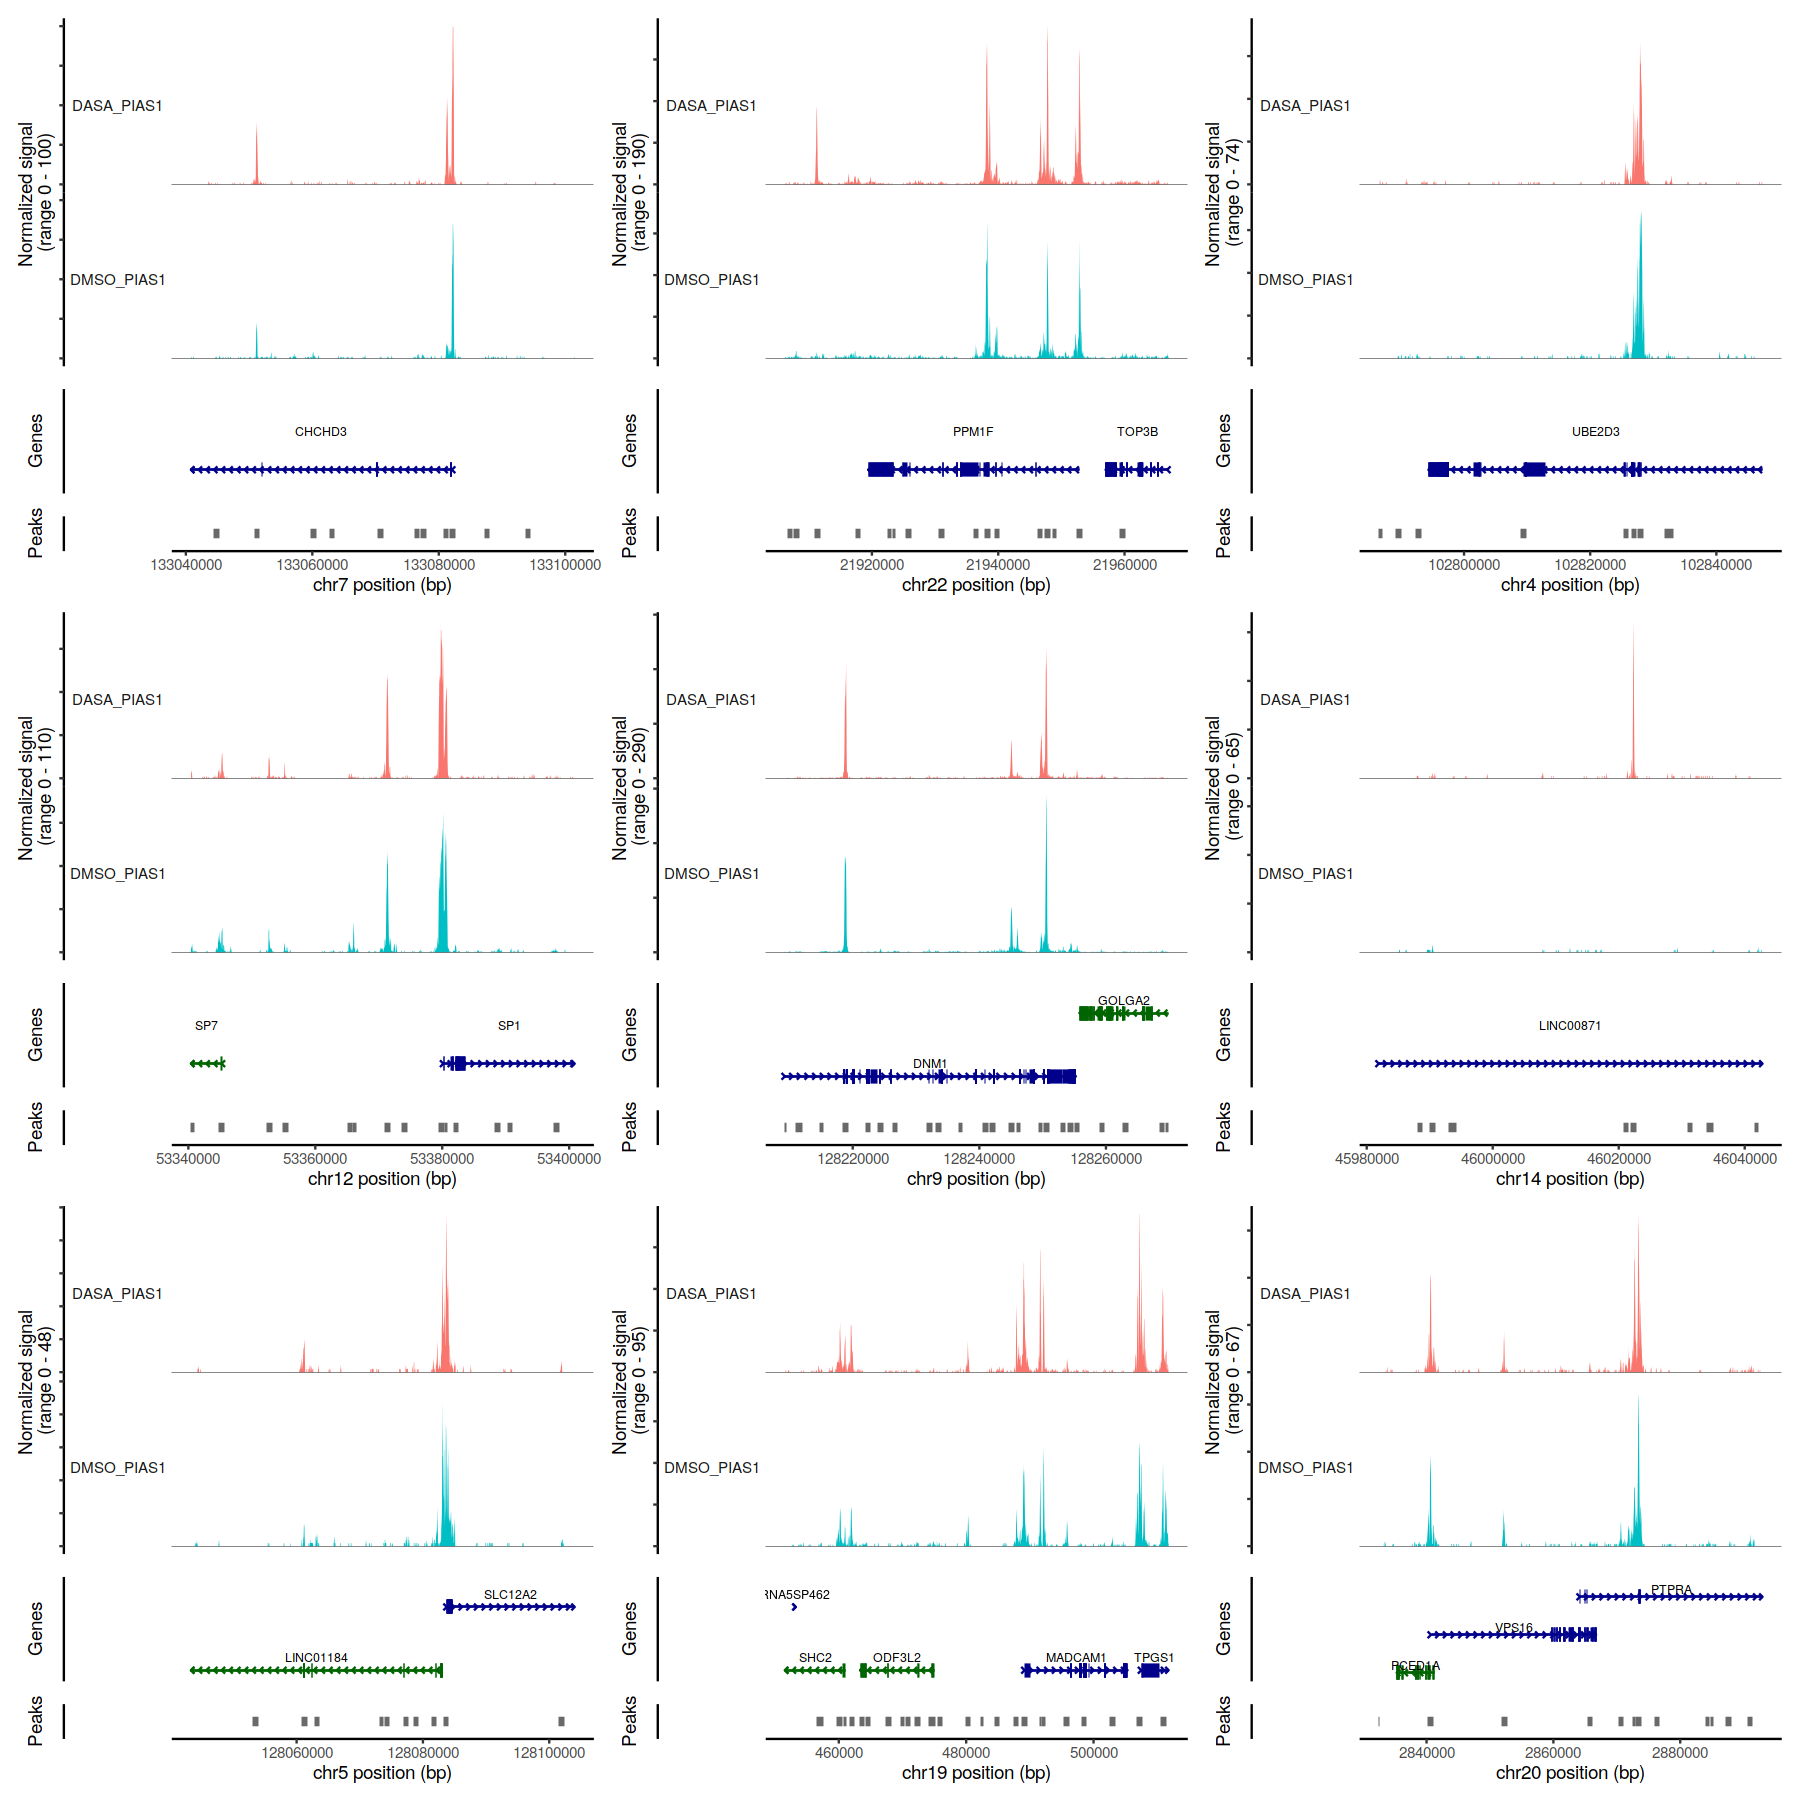

In [59]:
CoveragePlot(
  object = subset(integrated, 
                  subset = treatment_and_guidecapture == "DASA_PIAS1" | treatment_and_guidecapture == "DMSO_PIAS1"),
    region = rownames(da_atac_PIAS1)[1:9],
    extend.upstream = 40000,
    extend.downstream = 20000
)

### DASA HIC2 VS DASA NT

In [60]:
da_atac_DASA_HIC2_NT <- FindMarkers(
  object = integrated,
  ident.1 = "DASA_HIC2",
  ident.2 = "DASA_NT",
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

head(da_atac_DASA_HIC2_NT)

dim(da_atac_DASA_HIC2_NT)

# Sort the dataframe by a log2FC in descending order
da_atac_DASA_HIC2_NT <- da_atac_DASA_HIC2_NT[order(da_atac_DASA_HIC2_NT$avg_log2FC, decreasing = TRUE), ]
write.csv(da_atac_DASA_HIC2_NT, 
file = '{PATH_9}')
head(da_atac_DASA_HIC2_NT, 20)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr22-19933251-19934308 9.503700e-96 4.374050   0.363 0.021 2.652464e-90
chr22-23191892-23192845 1.889645e-85 2.870125   0.459 0.077 5.273960e-80
chr22-23176926-23177802 3.279474e-84 2.217832   0.576 0.167 9.152947e-79
chr22-29733698-29734558 1.084732e-67 4.647932   0.253 0.011 3.027466e-62
chr11-64598853-64599781 7.345023e-60 4.759039   0.221 0.009 2.049981e-54
chr7-47568307-47569258  9.652173e-56 3.552481   0.272 0.024 2.693902e-50

[1] 7145    5

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr4-168257537-168258490 4.623357e-53 5.596211   0.181 0.003 1.290370e-47
chr7-128116669-128117601 3.204012e-50 5.531988   0.168 0.004 8.942334e-45
chr3-10763876-10765358   1.545156e-41 5.493037   0.141 0.003 4.312499e-36
chr11-69264362-69265503  3.149171e-32 5.299103   0.115 0.003 8.789273e-27
chr10-69107390-69108284  9.910451e-29 5.068601   0.104 0.003 2.765987e-23
chr11-44916483-44917470  1.125400e-40 4.910012   0.147 0.006 3.140969e-35
chr1-94023830-94024744   6.312230e-43 4.810219   0.160 0.006 1.761731e-37
chr4-44523996-44525063   2.196134e-33 4.787492   0.125 0.005 6.129365e-28
chr11-64598853-64599781  7.345023e-60 4.759039   0.221 0.009 2.049981e-54
chr22-29733698-29734558  1.084732e-67 4.647932   0.253 0.011 3.027466e-62
chr11-6251937-6252746    4.092303e-40 4.642090   0.157 0.006 1.142154e-34
chr9-106203487-106204430 2.206906e-29 4.588066   0.115 0.005 6.159430e-24
chr3-178790058-178790970 9.764102e-42 4.585982   0.160 0.007 2.725141e-36
chr1-228225518-228226440 5.907969e-27 4.579647   0.104 0.005 1.648902e-21
chr2-239115028-239115942 3.024656e-39 4.555927   0.152 0.007 8.441754e-34
chr14-93748037-93749095  5.012287e-40 4.455514   0.160 0.008 1.398919e-34
chr6-97591108-97592026   1.889601e-26 4.408606   0.104 0.005 5.273838e-21
chr22-19933251-19934308  9.503700e-96 4.374050   0.363 0.021 2.652464e-90
chr9-83503571-83504494   7.070579e-28 4.332508   0.112 0.006 1.973384e-22
chr1-209801833-209802751 2.485744e-48 4.253388   0.197 0.011 6.937661e-43

Warning message:
“Removed 20 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 72 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 52 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 90 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 23 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 139 rows containing missing values (`geom_segment()`).”


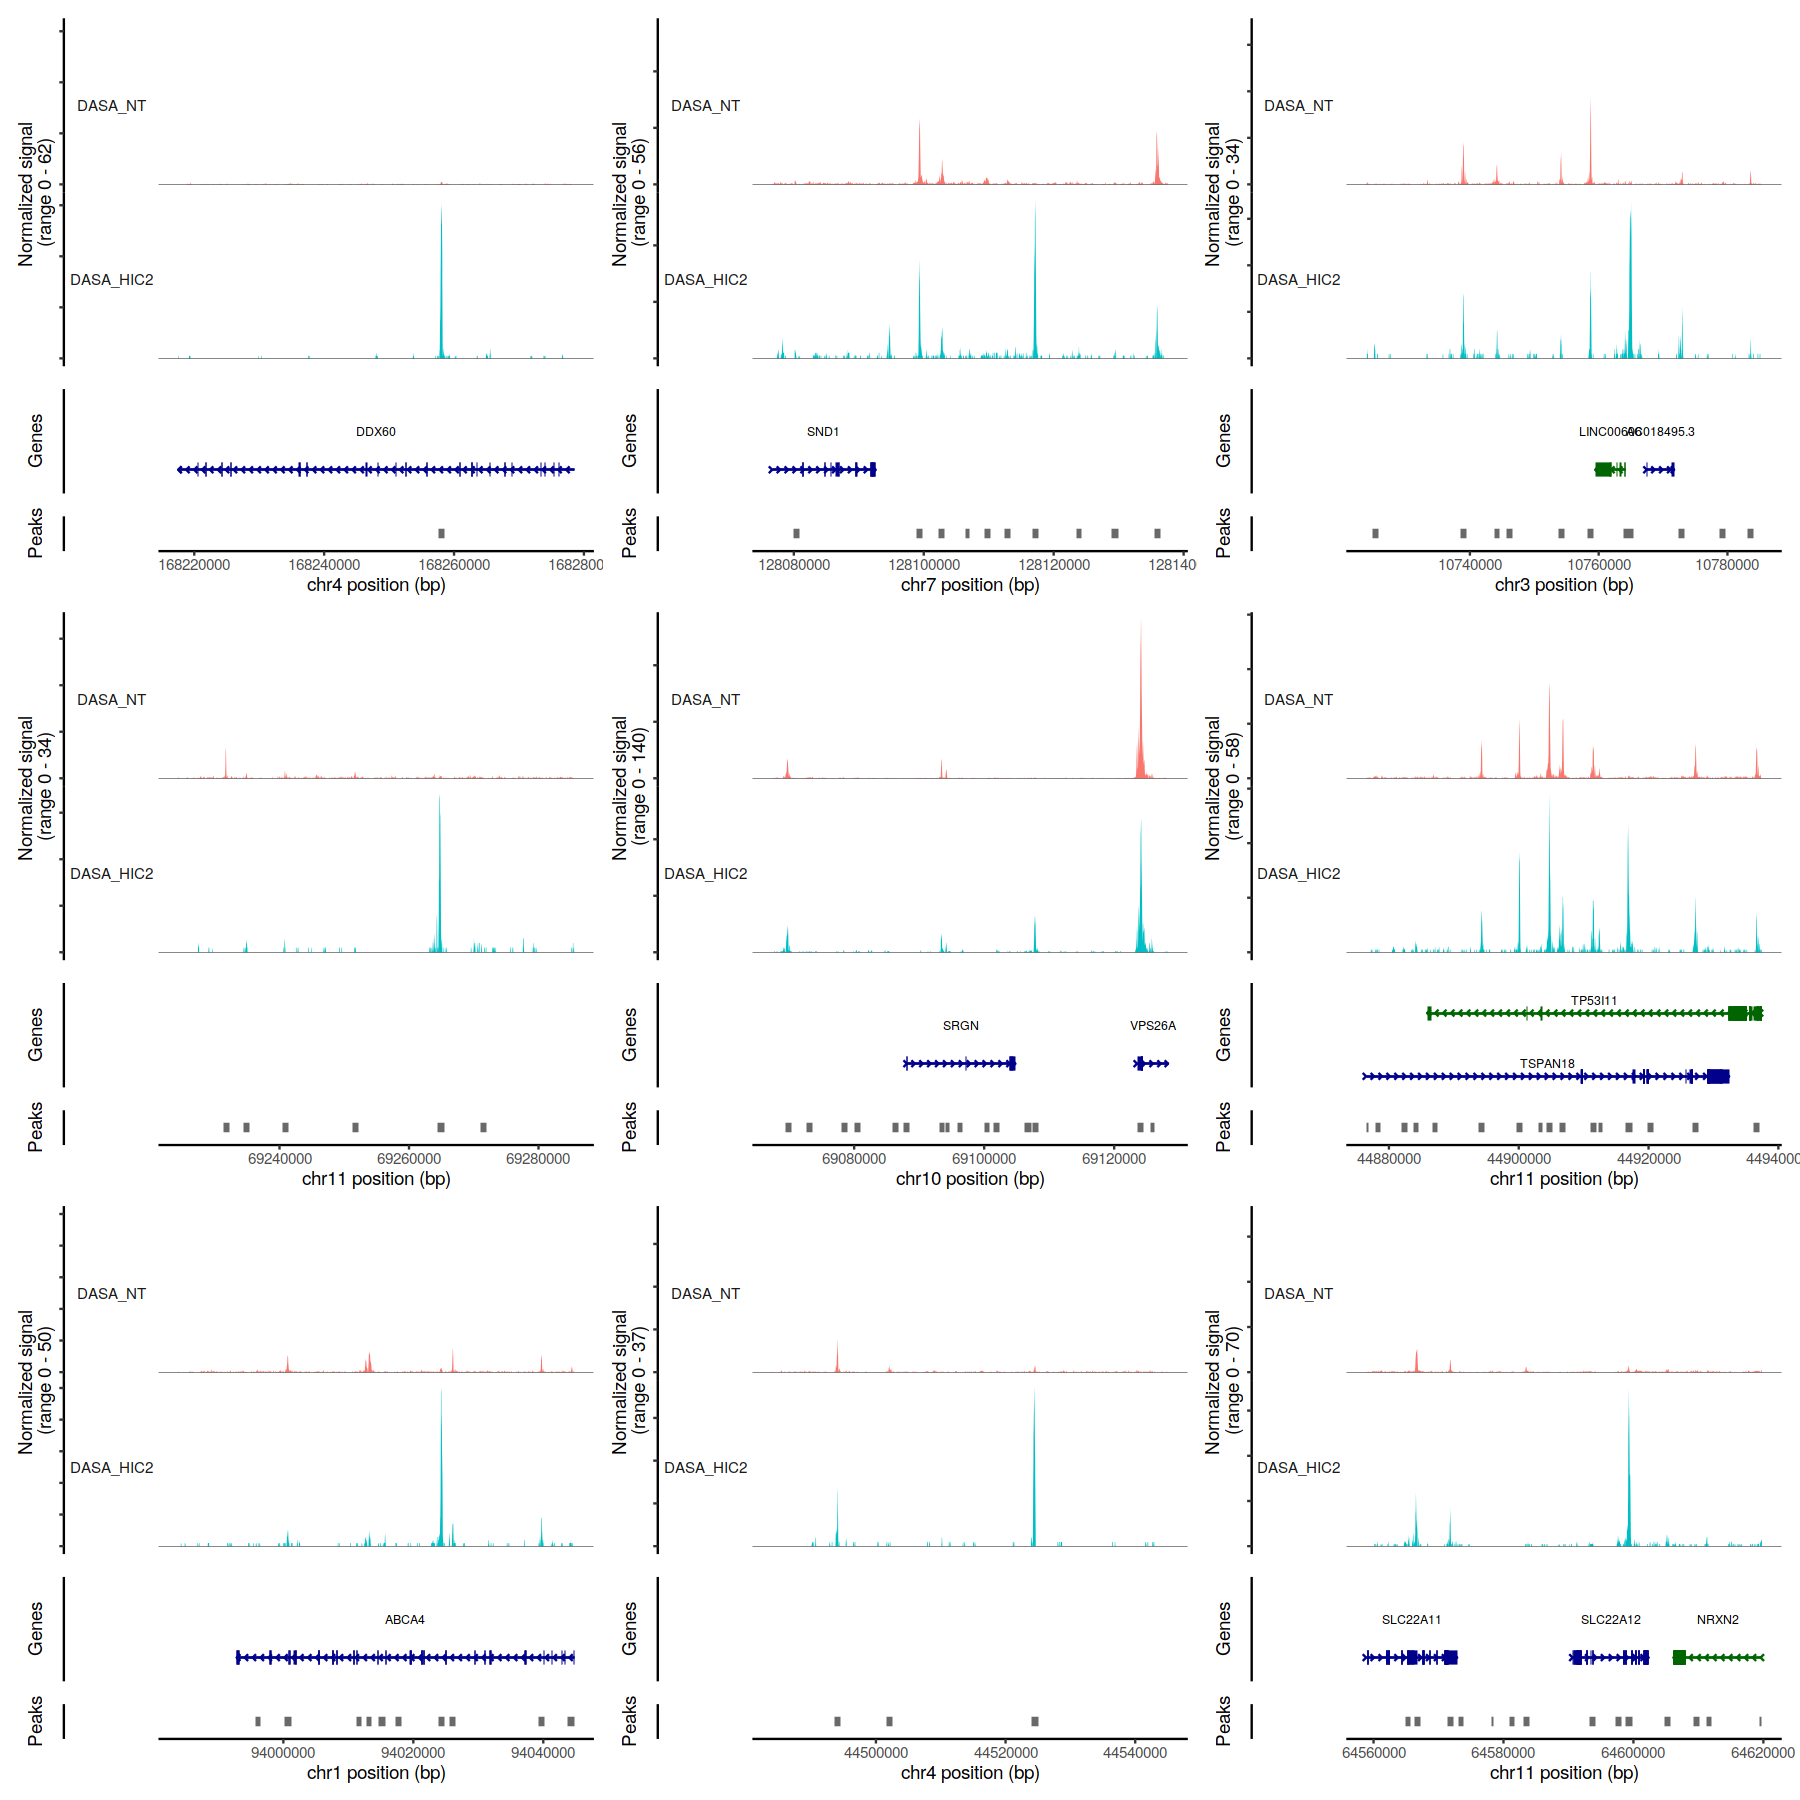

In [61]:
CoveragePlot(
  object = subset(integrated, 
                  subset = treatment_and_guidecapture == "DASA_HIC2" | treatment_and_guidecapture == "DASA_NT"),
    region = rownames(da_atac_DASA_HIC2_NT)[1:9],
    extend.upstream = 40000,
    extend.downstream = 20000
)

### DASA PIAS1 VS DASA NT

In [62]:
da_atac_DASA_PIAS1_NT <- FindMarkers(
  object = integrated,
  ident.1 = "DASA_PIAS1",
  ident.2 = "DASA_NT",
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

head(da_atac_DASA_PIAS1_NT)

dim(da_atac_DASA_PIAS1_NT)

# Sort the dataframe by a log2FC in descending order
da_atac_DASA_PIAS1_NT <- da_atac_DASA_PIAS1_NT[order(da_atac_DASA_PIAS1_NT$avg_log2FC, decreasing = TRUE), ]
write.csv(da_atac_DASA_PIAS1_NT, file = '{PATH_10}')
head(da_atac_DASA_PIAS1_NT, 20)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr8-125941827-125942776 9.123703e-17  2.805822  0.123 0.019 2.546407e-11
chr15-68053859-68054711  1.300720e-16 -1.994762  0.068 0.268 3.630284e-11
chr13-90526430-90527345  2.034002e-15  2.058207  0.168 0.042 5.676858e-10
chr1-186195133-186196059 5.693742e-13  1.643828  0.191 0.065 1.589112e-07
chr8-53492229-53493158   1.231910e-12  1.222323  0.275 0.129 3.438236e-07
chr4-152177269-152178211 2.541903e-12  1.745418  0.162 0.052 7.094399e-07

[1] 4790    5

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr8-125941827-125942776  9.123703e-17 2.805822   0.123 0.019 2.546407e-11
chr8-125986397-125987441  1.630849e-11 2.260617   0.107 0.023 4.551668e-06
chr5-43804480-43805401    3.622202e-10 2.109188   0.104 0.025 1.010949e-04
chr13-90526430-90527345   2.034002e-15 2.058207   0.168 0.042 5.676858e-10
chr3-174133354-174134265  8.552402e-10 2.054233   0.104 0.026 2.386958e-04
chr11-94077607-94078705   1.108567e-09 1.909836   0.110 0.031 3.093987e-04
chr4-152177269-152178211  2.541903e-12 1.745418   0.162 0.052 7.094399e-07
chr1-186195133-186196059  5.693742e-13 1.643828   0.191 0.065 1.589112e-07
chr13-112101278-112102146 3.611686e-09 1.637845   0.133 0.045 1.008014e-03
chr1-233665344-233666250  6.340978e-09 1.604200   0.129 0.044 1.769754e-03
chr8-48466332-48467249    2.057460e-11 1.593447   0.175 0.061 5.742330e-06
chr22-17139832-17140755   6.363014e-12 1.568620   0.194 0.065 1.775904e-06
chr13-57891292-57892283   7.061911e-08 1.503364   0.126 0.046 1.970965e-02
chr9-32631789-32632708    7.420269e-08 1.497443   0.126 0.046 2.070982e-02
chr13-73220838-73221785   1.384912e-06 1.494634   0.100 0.039 3.865261e-01
chr6-167099940-167100859  3.836704e-07 1.483405   0.113 0.045 1.070816e-01
chr16-65768946-65769720   2.048572e-07 1.475824   0.123 0.045 5.717524e-02
chr4-35760616-35761590    1.332068e-11 1.453059   0.197 0.079 3.717776e-06
chr10-72903738-72904660   4.465552e-08 1.411581   0.142 0.057 1.246327e-02
chr3-35439342-35440274    1.020910e-08 1.386297   0.155 0.065 2.849338e-03

Warning message:
“Removed 9 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 38 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 115 rows containing missing values (`geom_segment()`).”


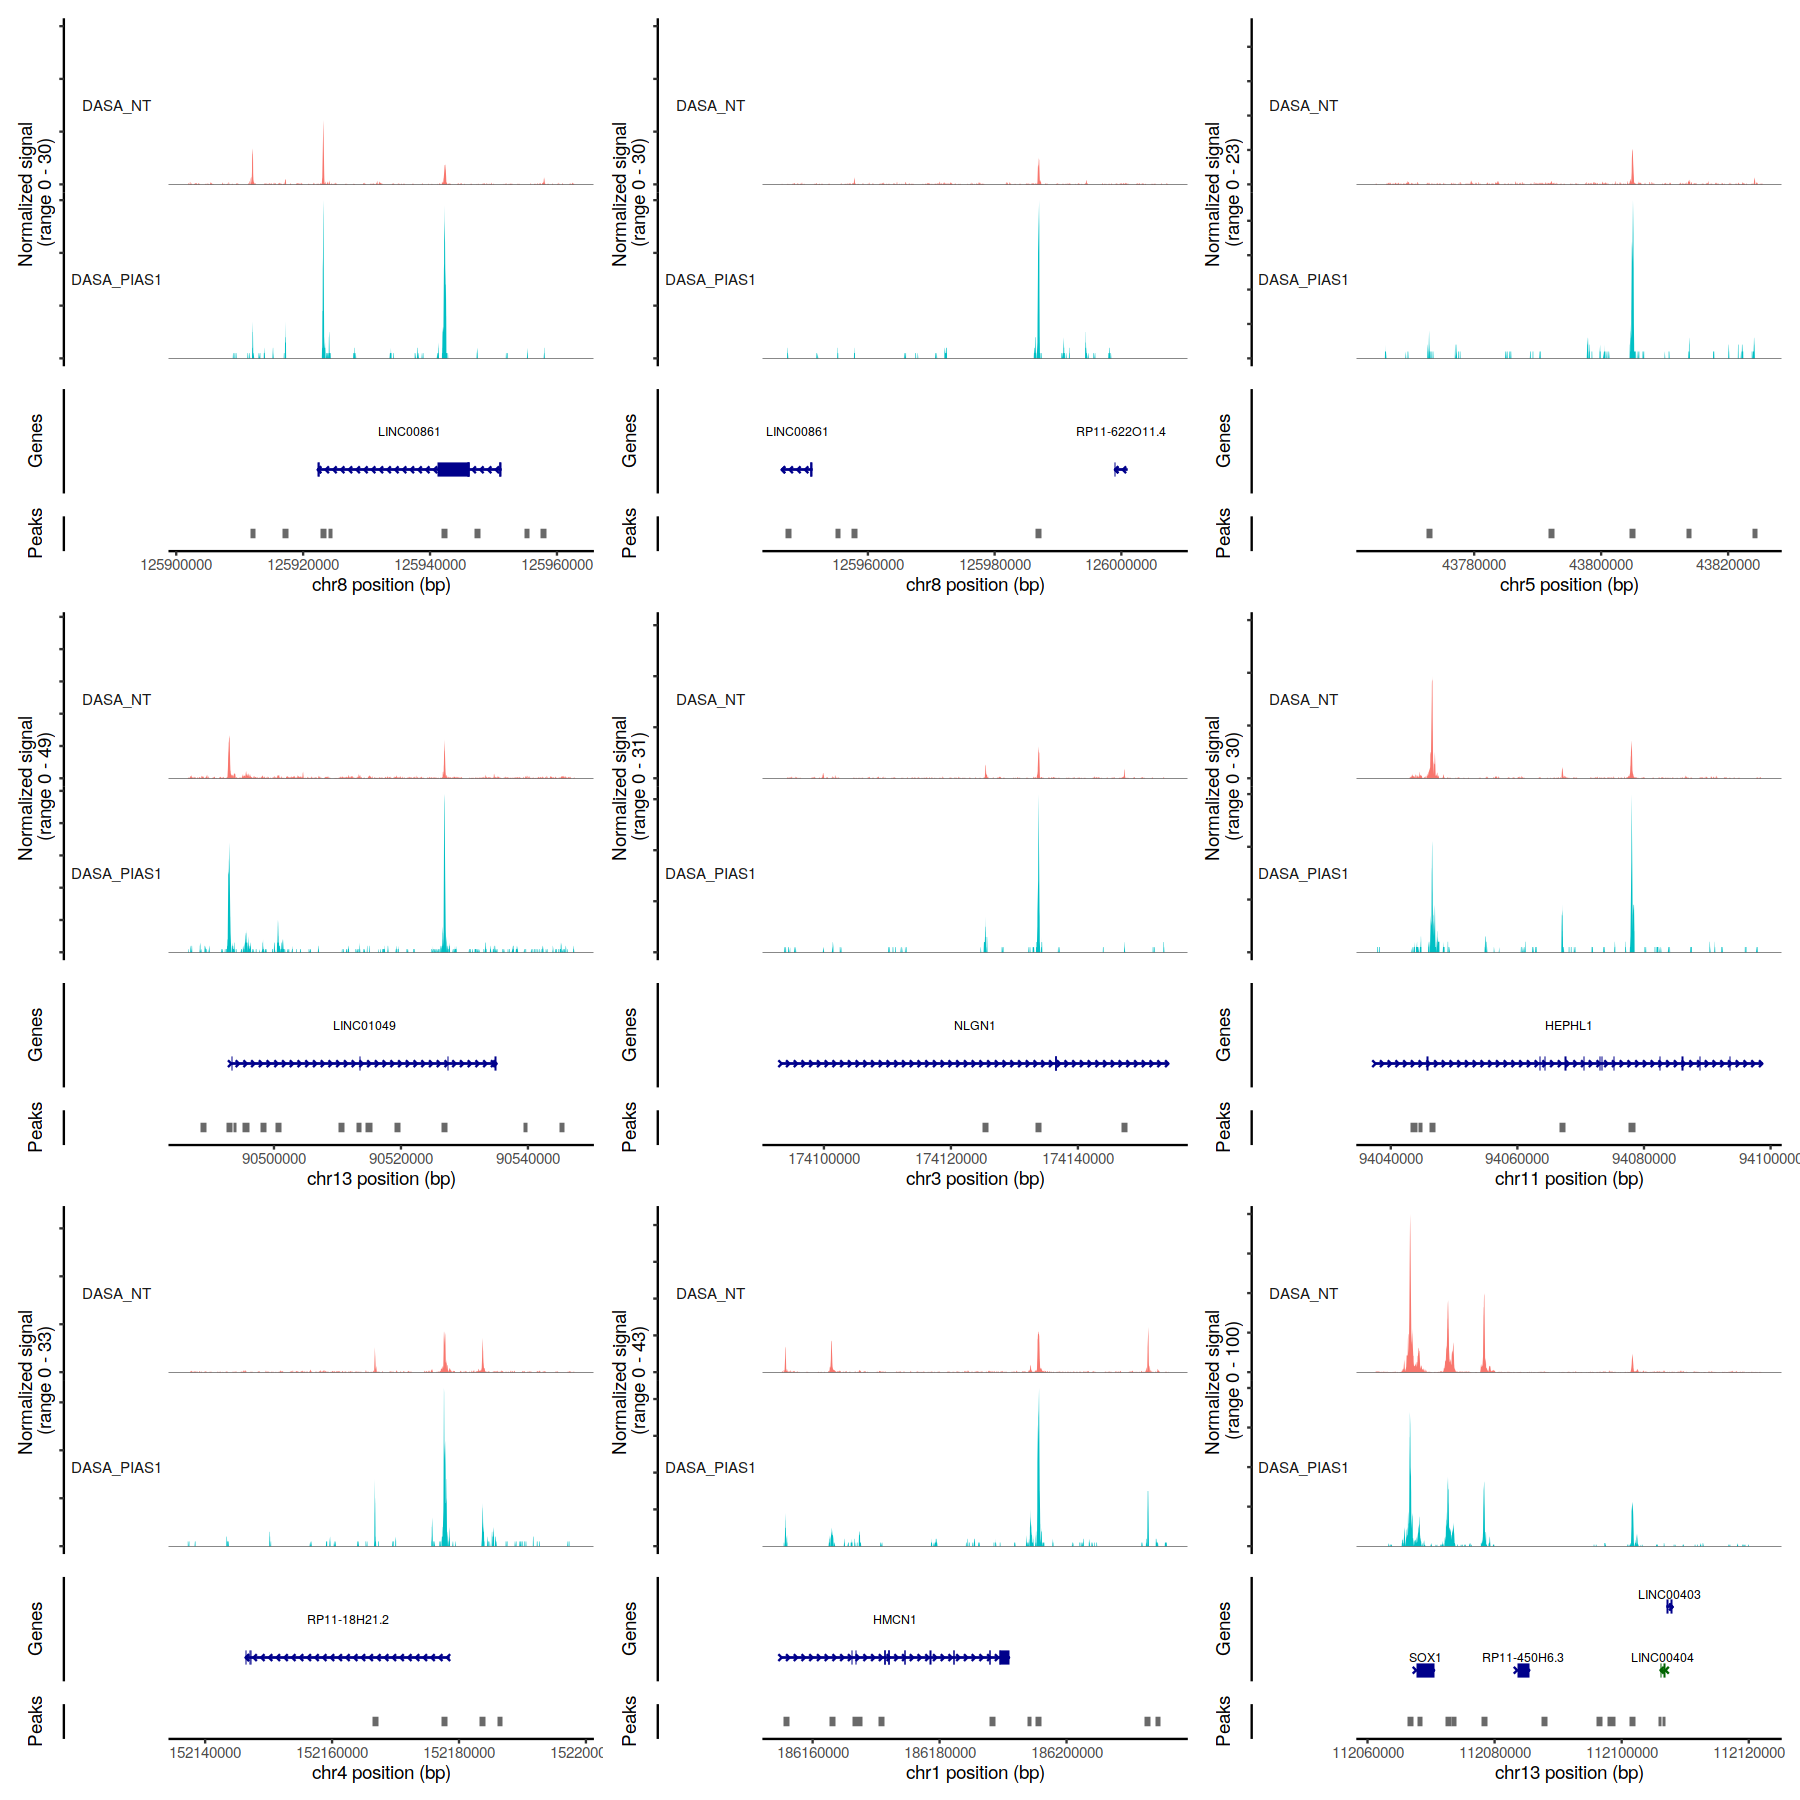

In [63]:
CoveragePlot(
  object = subset(integrated, 
                  subset = treatment_and_guidecapture == "DASA_PIAS1" | treatment_and_guidecapture == "DASA_NT"),
    region = rownames(da_atac_DASA_PIAS1_NT)[1:9],
    extend.upstream = 40000,
    extend.downstream = 20000
)

# Compute WNN UMAP

In [64]:
integrated

An object of class Seurat 
345160 features across 7994 samples within 4 assays 
Active assay: ATAC (279098 features, 0 variable features)
 3 other assays present: SCT, RNA, PRTB
 2 dimensional reductions calculated: integrated_lsi, atac.umap

To compute a wnn umap we need to recompute RNA umap.

In [ ]:
# recompute rna umap
DefaultAssay(integrated) <- "RNA"
integrated <- SCTransform(integrated, vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), verbose = FALSE)
integrated <- RunPCA(integrated, verbose = FALSE)
integrated <- RunUMAP(integrated, dims = 1:30, verbose = FALSE, 
                      reduction.name = "rna.umap", reduction.key = "rnaUMAP_")

integrated <- FindNeighbors(integrated, dims = 1:30, verbose = FALSE)
integrated <- FindClusters(integrated, verbose = FALSE)

options(repr.plot.width = 14, repr.plot.height = 6)
p1 <- DimPlot(integrated, reduction = "rna.umap", group.by = "treatment_and_guidecapture") + ggtitle("RNA")
p2 <- DimPlot(integrated, reduction = "atac.umap", group.by = "treatment_and_guidecapture") + ggtitle("ATAC")
p1+p2

In [66]:
# compute wnn umap
integrated <- FindMultiModalNeighbors(
  integrated, reduction.list = list("pca", "integrated_lsi"), 
  dims.list = list(1:30, 2:50))

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.



Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



In [67]:
integrated <- RunUMAP(integrated, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
integrated <- FindClusters(integrated, graph.name = "wsnn", algorithm = 3, verbose = FALSE)

15:05:03 UMAP embedding parameters a = 0.9922 b = 1.112



15:05:04 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

15:05:07 Initializing from normalized Laplacian + noise (using irlba)

15:05:07 Commencing optimization for 500 epochs, with 251420 positive edges

15:05:18 Optimization finished



In [68]:
p3 <- DimPlot(integrated, group.by = "treatment_and_guidecapture", reduction = "wnn.umap") + ggtitle("wnn")

# Figure 3F

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 6)
grid.arrange(p1, p2, p3, nrow = 1, ncol = 3)

In [74]:
# Extend the list by adding more distinguishable colors
colors <- c(
    colors_brewer,
    "#8B0000",  # Dark Red
    "#FF4500",  # Orange Red
    "#2E8B57",  # Sea Green
    "#6A5ACD",  # Slate Blue
    "#DB7093",  # Pale Violet Red
    "#FF69B4",  # Hot Pink
    "#D2691E",  # Chocolate
    "#20B2AA",  # Light Sea Green
    "#FFD700",  # Gold
    "#C71585",  # Medium Violet Red
    "#00CED1",  # Dark Turquoise
    "#FFB6C1",  # Light Pink
    "#8A2BE2",  # Blue Violet
    "#7FFF00",  # Chartreuse
    "#D2B48C",  # Tan
    "#FA8072",  # Salmon
    "#F08080",  # Light Coral
    "#E9967A",  # Dark Salmon
    "#4682B4",  # Steel Blue
    "#9ACD32",  # Yellow Green
    "#40E0D0",  # Turquoise
    "#FF6347",  # Tomato
    "#4169E1",  # Royal Blue
    "#6B8E23"   # Olive Drab
)

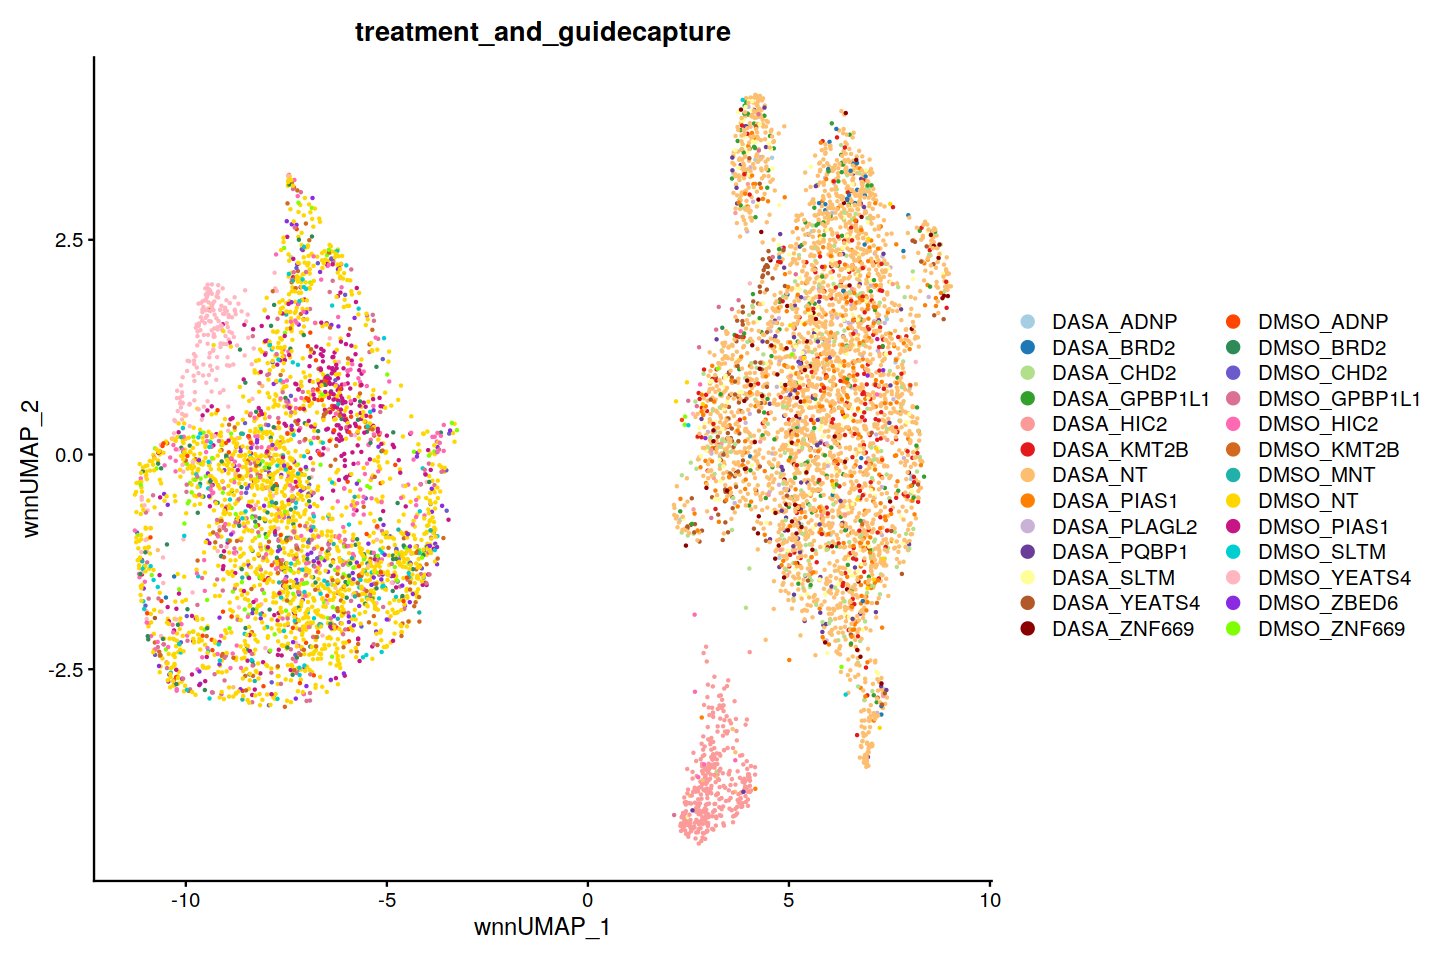

In [77]:
options(repr.plot.width = 12, repr.plot.height = 8)
DimPlot(integrated, reduction = "wnn.umap", group.by = "treatment_and_guidecapture", cols = colors)

In [72]:
# save integrated sobj
saveRDS(integrated, file = '{PATH_11}')

# Figure 3C

In [ ]:
library(Seurat)
library(Signac)
library(ggplot2)
library(dplyr)

In [ ]:
# read rds
sobj <- readRDS('{PATH_1}')
DefaultAssay(sobj) <- "SCT"
# get names of unique identities
ident_names <- levels(Idents(sobj))
# print(ident_names)

# subset for string after _ and store as list called genes_to_plot
genes_to_plot <- unique(unlist(lapply(strsplit(ident_names, "_"), function(x) x[length(x)])))
genes_to_plot <- genes_to_plot[genes_to_plot != "NT"]
print(genes_to_plot)


In [ ]:
# Function to reorder items (identities or features)
reorder_items <- function(items, ident_names) {
  # Sort items alphabetically (A to Z)
  items <- sort(items)
  
  # Create ordered lists
  paired_items <- c()
  single_items <- c()
  for (item in items) {
    dmso <- paste0("DMSO_", item)
    dasa <- paste0("DASA_", item)
    if (dmso %in% ident_names && dasa %in% ident_names) {
      paired_items <- c(paired_items, item)
    } else {
      single_items <- c(single_items, item)
    }
  }
  
  # Combine paired items first, then single items
  c(paired_items, single_items)
}

# Reorder identities
new_ident_order <- reorder_items(unique(unlist(lapply(strsplit(ident_names, "_"), function(x) x[length(x)]))), ident_names)
new_ident_order <- unlist(lapply(new_ident_order, function(gene) c(paste0("DMSO_", gene), paste0("DASA_", gene))))
new_ident_order <- new_ident_order[new_ident_order %in% ident_names]

# Reorder features (x-axis)
new_feature_order <- reorder_items(genes_to_plot, ident_names)

# Set the new identity order
sobj$reordered_idents <- factor(Idents(sobj), levels = rev(new_ident_order))
Idents(sobj) <- "reordered_idents"

# Create the DotPlot with reordered identities and features
DotPlot(sobj, features = new_feature_order) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))